In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame
from MyLearner import MyLearner

from MyScorer import MyScorer
from MyPlotter import MyPlotter

import pandas as pd
import numpy as np
import string
import itertools

import math
import scipy.stats as sts
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

import seaborn as sns
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import ensemble as ens
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score
import sklearn.feature_selection as feature_selection
import sklearn.preprocessing as prepc
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.multiclass import OneVsOneClassifier as ovo
from sklearn.multiclass import OutputCodeClassifier as occ
import sklearn
import sklearn.metrics as metrics
from rfpimp import dropcol_importances
from rfpimp import importances
import imblearn.over_sampling as imbOVS
import imblearn.under_sampling as imbUDS
import imblearn.combine as imbCMB

from dabl.plot import class_hists

c:\00_data\python38\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#import train dataset
filename_tr = 'train.csv'
data_train = pd.read_csv(filename_tr)

#import test dataset
filename_tes = 'test.csv'
data_test = pd.read_csv(filename_tes)

### Training Set

In [3]:
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Test Set

In [4]:
data_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Checking missing values in training set

In [5]:
nulls = data_train.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
N = len(data_train.index)
nulls.insert(1, 'percent', ['{0:.2%}'.format(nulls.loc['Age'][0] / N), 
                            '{0:.2%}'.format(nulls.loc['Cabin'][0] / N),
                            '{0:.2%}'.format(nulls.loc['Embarked'][0] / N)])
nulls

,count,percent
Age,177,19.87%
Cabin,687,77.10%
Embarked,2,0.22%


Seems to be a lot of missing values in 'Age' and 'Cabin'.

As I concluded from preliminary analysis, the Age is one of the critical and must be treated first.

The Cabin and Embarked are probably not important in Survival prediction.

I will come to nulls later but for now lets look on distributions.

### Checking missing values in test set

In [6]:
nulls = data_test.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
nulls

,count
Age,86
Fare,1
Cabin,327


#### Calculate survival rate

In [7]:
#how many died
N_surv0 = len(data_train.loc[data_train['Survived']==0])
#how many survived
N_surv1 = len(data_train.loc[data_train['Survived']==1])

print('Deads: {0} ({1:.2%})'.format(N_surv0, N_surv0 / N))
print('Survivals: {0} ({1:.2%})'.format(N_surv1, N_surv1 / N))

Deads: 549 (61.62%)
Survivals: 342 (38.38%)


Well, only 1/3 survived. That was expectable though.

In [8]:
# #prepare data for plots
# target = 'Survived'
# features = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

In [9]:
data = data_train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

#encode categorical variables
df1 = data['Sex'].apply(lambda i: 1 if i=='male' else 0)
df2 = data['Embarked'].apply(lambda i: 0 if i=='C' else (1 if i=='Q' else 2))
data = pd.concat([data.drop(columns=['Sex', 'Embarked']), df1, df2], axis=1)

#add family size
data['famsize'] = data['SibSp'] + data['Parch']

#numerical data
data_num = data[['Age', 'Fare',]]
#categorical data
data_cat = data[['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch', 'famsize']]

# #encode categorical variables
# df1 = data_cat['Sex'].apply(lambda i: 1 if i=='male' else 0)
# df2 = data_cat['Embarked'].apply(lambda i: 0 if i=='C' else (1 if i=='Q' else 2))
# data_cat = pd.concat([data_cat[['Pclass', 'SibSp', 'Parch']], df1, df2], axis=1)

# #add family size
# data_cat['famsize'] = data_cat['SibSp'] + data_cat['Parch']

# data = pd.concat([data[target], data_num, data_cat], axis=1)

In [10]:
data.head(5)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,famsize
0,0,3,22.0,1,0,7.2500,1,2,1
1,1,1,38.0,1,0,71.2833,0,0,1
2,1,3,26.0,0,0,7.9250,0,2,0
3,1,1,35.0,1,0,53.1000,0,2,1
4,0,3,35.0,0,0,8.0500,1,2,0


### Plotting Variables

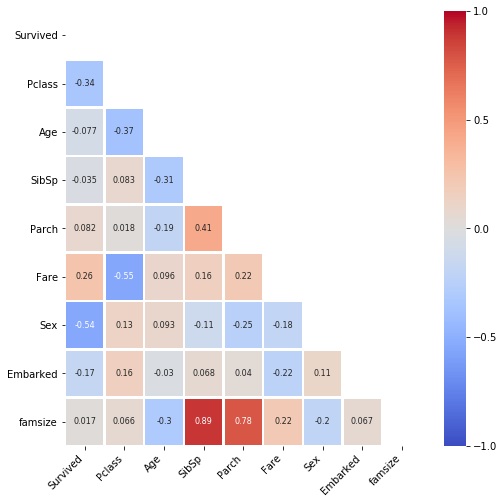

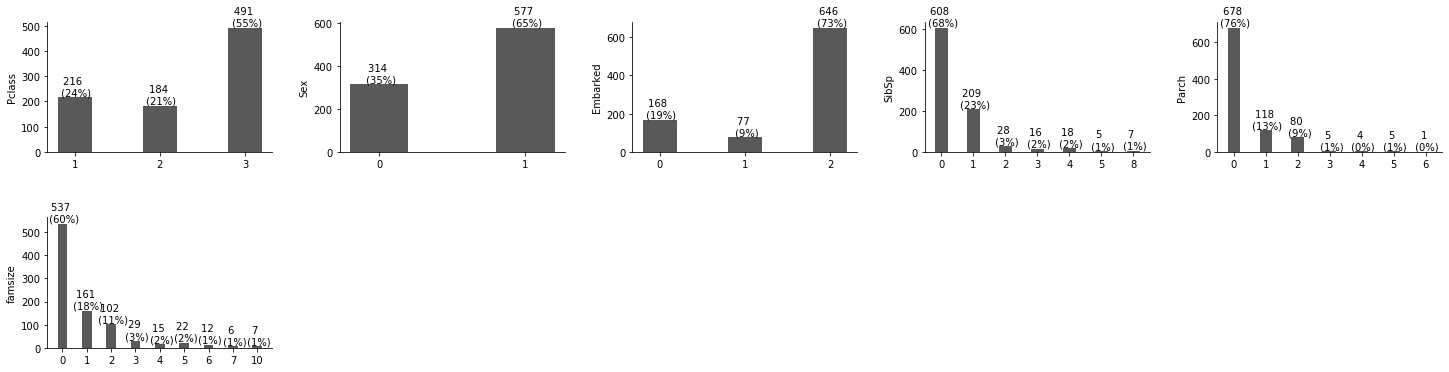

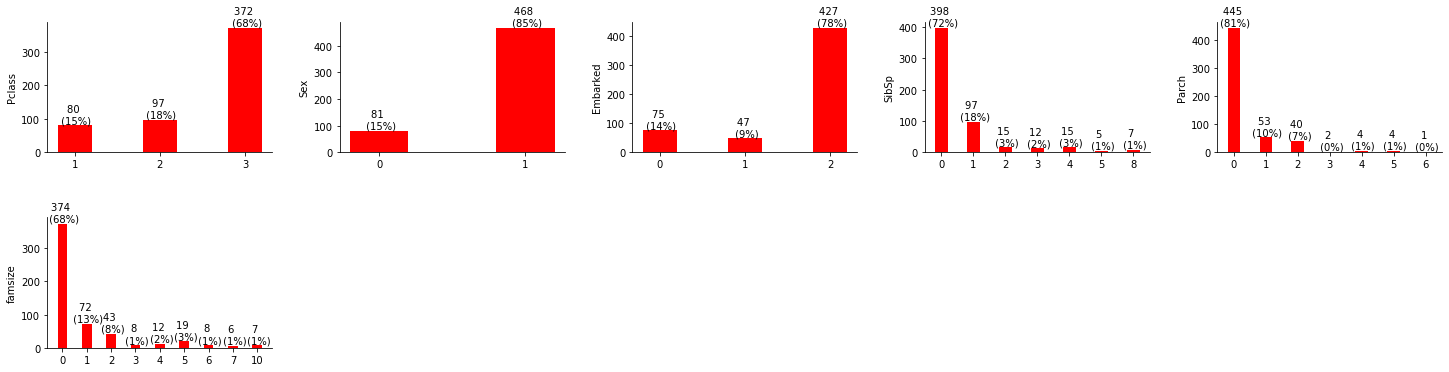

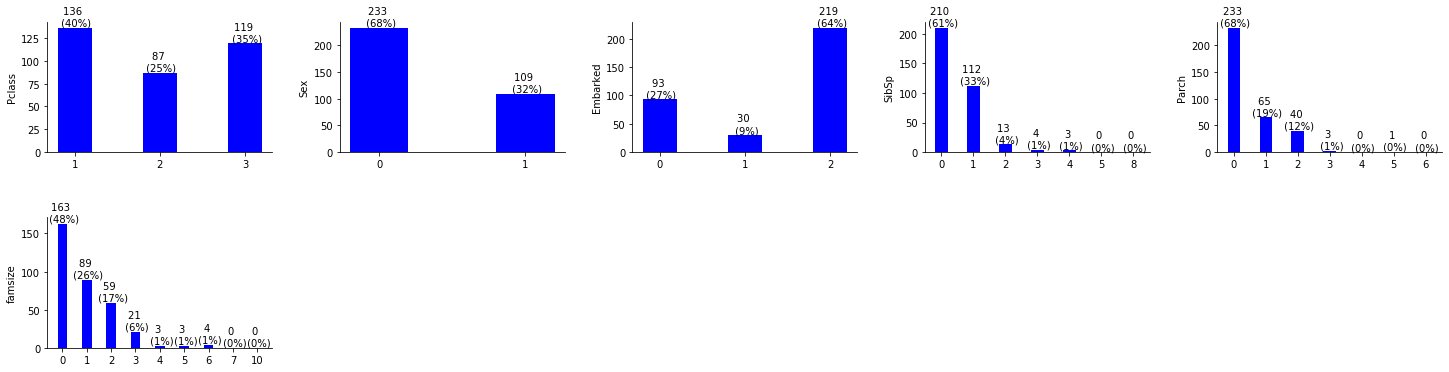

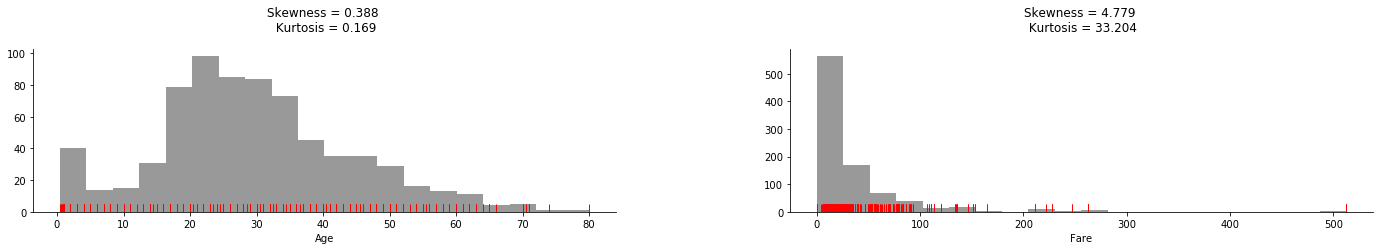

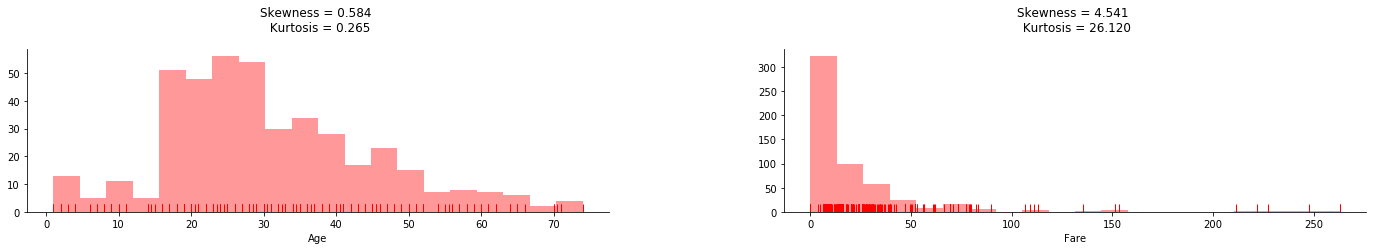

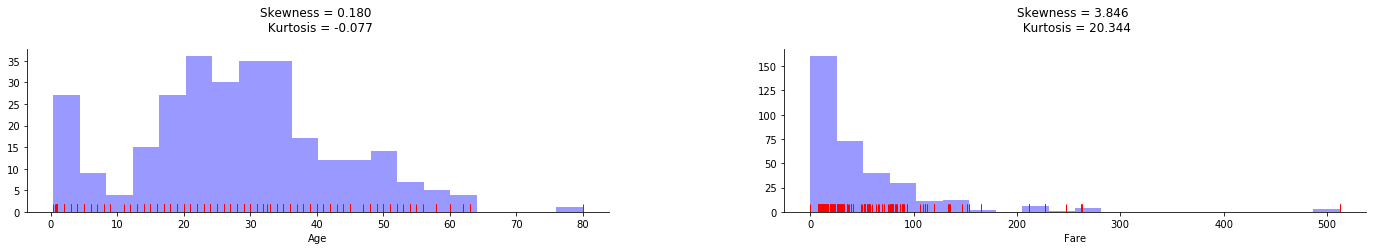

In [11]:
myplt = MyPlotter()

#plot correlation matrix
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
myplt.plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap='coolwarm')


grd = list(data_cat.columns)
grd_n = len(grd)
grd_cols_n = 5
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 5

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n = len(data.loc[data[col]==i, col].index)
        fr = n / len(data.index)
        freq.append([n])
        frc.append([fr])

    df_freq = pd.DataFrame(freq, columns=['all'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['all'], index=data_cat[col].unique()).T
    labs = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['all'], df_frc.loc['all'])]
    myplt.plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs],
                           plots_labels=None,
                           plots_colors=['0.35'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (non-survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n0 = len(data.loc[(data['Survived']==0) & (data[col]==i), col].index)
        fr0 = n0 / N_surv0
        freq.append([n0])
        frc.append([fr0])

    df_freq = pd.DataFrame(freq, columns=['non_survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['non_survivals'], index=data_cat[col].unique()).T
    labs0 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['non_survivals'], df_frc.loc['non_survivals'])]
    myplt.plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs0],
                           plots_labels=None,
                           plots_colors=['r'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n1 = len(data.loc[(data['Survived']==1) & (data[col]==i), col].index)
        fr1 = n1 / N_surv1
        freq.append([n1])
        frc.append([fr1])

    df_freq = pd.DataFrame(freq, columns=['survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['survivals'], index=data_cat[col].unique()).T
    labs1 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['survivals'], df_frc.loc['survivals'])]
    myplt.plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs1],
                           plots_labels=None,
                           plots_colors=['b'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    

    
grd = list(data_num.columns)
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data[col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "0"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (NON-SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==0, col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "r"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==1, col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))


In [12]:
#Concatinate train & test data
data_tot = pd.concat([data_train, data_test], ignore_index=True)

In [13]:
#encoding Name
def name_encoder(data):
    data_encoded = []
    for i in data['Name']:
        lname0 = i.split(',')[0].strip() #last name
        ttl = i.split(',')[1].split('.')[0].strip() #title
        lname1 = (i.split('(')[-1].split(')')[0].split()[-1].strip() if '(' in i else '').replace('\"','') #second last name
        data_encoded.append([lname0, lname1, ttl])
    data_encoded = pd.DataFrame(data_encoded, columns=['lname0', 'lname1', 'ttl'], index=data.index)
    return pd.concat([data.reset_index(), data_encoded], axis=1).drop(columns=['index'])

In [14]:
data_tot = name_encoder(data_tot)
data_tot

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Thayer,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Peel,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Spector,,Mr
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,,Dona
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,,Mr
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Ware,,Mr


In [15]:
#unique titles
ttl = data_tot['ttl'].unique()
#counts
ttl = [[i, len(data_tot.loc[data_tot['ttl']==i])] for i in ttl]
#to DataFrame
ttl = pd.DataFrame(ttl, columns=['ttl', 'ttl_n'])
ttl

,ttl,ttl_n
0,Mr,757
1,Mrs,197
2,Miss,260
3,Master,61
4,Don,1
5,Rev,8
6,Dr,8
7,Mme,1
8,Ms,2
9,Major,2


In [16]:
data_tot.loc[data_tot['ttl']=='Dr']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
245,246,0.0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,Minahan,,Dr
317,318,0.0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,Moraweck,,Dr
398,399,0.0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,Pain,,Dr
632,633,1.0,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C,Stahelin-Maeglin,,Dr
660,661,1.0,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S,Frauenthal,,Dr
766,767,0.0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,Brewe,,Dr
796,797,1.0,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Leader,Farnham,Dr
1184,1185,NaN,1,"Dodge, Dr. Washington",male,53.0,1,1,33638,81.8583,A34,S,Dodge,,Dr


### There is only one woman Dr

In [17]:
def title_encoder(data):
    mask = {'Don':'Mr',
            'Sir':'Mr',
            'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'the Countess':'Mrs',
            'Dona':'Mrs',
            'Mlle':'Miss',
            'Ms':'Miss',
            'Major':'Mr',
            'Col':'Mr',
            'Capt':'Mr',
            'Rev':'Mr',
            'Dr':'Mr'}
    
    df = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
    data = pd.concat([data.drop(columns=['ttl']), df], axis=1)
    if 797 in data['PassengerId'].values:
        data.loc[data_tot['PassengerId']==797, 'ttl'] = 'Mrs'
    mask = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4}
    df = data['ttl'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['ttl']), df], axis=1)

In [18]:
data_tot = title_encoder(data_tot)
# data_tot

In [19]:
data_tot.loc[data_tot['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,,3
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,Evelyn,2


In [20]:
df = data_tot.query('Ticket.str.contains("1135")')
df.sort_values(by='Ticket')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
782,783,0.0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S,Long,,1
377,378,0.0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C,Widener,,1
965,966,NaN,1,"Geiger, Miss. Amalie",female,35.0,0,0,113503,211.5000,C130,C,Geiger,,3
966,967,NaN,1,"Keeping, Mr. Edwin",male,32.5,0,0,113503,211.5000,C132,C,Keeping,,1
1109,1110,NaN,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5000,C80,C,Widener,Elkins,2
1298,1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C,Widener,,1
166,167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S,Chibnall,Bowerman,2
356,357,1.0,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S,Bowerman,,3
54,55,0.0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C,Ostby,,1
917,918,NaN,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C,Ostby,,3


In [21]:
nc = len(df.loc[df['Embarked']=='C'])
ns = len(df.loc[df['Embarked']=='S'])
n = len(df.index)

print('C: %d' % nc)
print('S: %d' % ns)
print('All: %d' % n)

C: 7
S: 5
All: 14


### So assigning both to C

In [22]:
#Encoding 'Embarked'
def embarked_encoder(data):
    if len(data.loc[data['Embarked'].isnull()].index)>0:
        data = data.fillna(value={'Embarked':'C'})
    mask = {'C':1, 'S':2, 'Q':3}
    df = data['Embarked'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['Embarked']), df], axis=1)

In [23]:
data_tot = embarked_encoder(data_tot)
# data_tot

### Grouping by ticket ID

In [24]:
def clean_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]).strip()
    text = ''.join(text.split())
    return text

In [25]:
#encoding Ticket
def ticket_encoder(data):
    df = data['Ticket'].apply(lambda i: clean_text(i)).to_frame()
    data = pd.concat([data.drop(columns=['Ticket']).reset_index(), df], axis=1)
    return data.drop(columns=['index'])

In [26]:
data_tot = ticket_encoder(data_tot)
# data_tot

In [27]:
data_tot.loc[data_tot['Ticket']=='PC17608']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,lname0,lname1,ttl,Embarked,Ticket
311,312,1.0,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,262.375,B57 B59 B63 B66,Ryerson,,3,1,PC17608
742,743,1.0,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,262.375,B57 B59 B63 B66,Ryerson,,3,1,PC17608
915,916,NaN,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.0,1,3,262.375,B57 B59 B63 B66,Ryerson,Borie,2,1,PC17608
950,951,NaN,1,"Chaudanson, Miss. Victorine",female,36.0,0,0,262.375,B61,Chaudanson,,3,1,PC17608
955,956,NaN,1,"Ryerson, Master. John Borie",male,13.0,2,2,262.375,B57 B59 B63 B66,Ryerson,,4,1,PC17608
1033,1034,NaN,1,"Ryerson, Mr. Arthur Larned",male,61.0,1,3,262.375,B57 B59 B63 B66,Ryerson,,1,1,PC17608
1266,1267,NaN,1,"Bowen, Miss. Grace Scott",female,45.0,0,0,262.375,NaN,Bowen,,3,1,PC17608


#### Прислуга!!!

In [28]:
def grps_by_size(grp):
    #group size > 1
    grp1 = None
    #group size == 1
    grp0 = None
    for g in grp.groups:
        grp_ = grp.get_group(g)
        if len(grp.get_group(g).index)>1:
            if grp1 is None:
                grp1 = grp_
            else:
                grp1 = pd.concat([grp1, grp_])
        else:
            if grp0 is None:
                grp0 = grp_
            else:
                grp0 = pd.concat([grp0, grp_])
    return (grp0, grp1)

In [29]:
print('Unique tickets: %d' % len(data_tot['Ticket'].unique()))
print('Non-unique tickets: %d' % (len(data_tot.index) - len(data_tot['Ticket'].unique())))

Unique tickets: 929
Non-unique tickets: 380


In [30]:
families0 = data_tot.loc[(data_tot['SibSp']>0) & (data_tot['Parch']==0)]
families1 = data_tot.loc[data_tot['Parch']>0]
singles = data_tot.loc[(data_tot['SibSp']==0) & (data_tot['Parch']==0)]

In [31]:
#singles
sig_grp = singles.groupby('Ticket')
#families NO children
fam0_grp = families0.groupby('Ticket')
#families w/children
fam1_grp = families1.groupby('Ticket')

#no family, unique ticket
sig0 = grps_by_size(sig_grp)[0]
#no family, matching tickets
sig1 = grps_by_size(sig_grp)[1]
#has family, no children, unique ticket
fam0 = grps_by_size(fam0_grp)[0]
#has family, no children, matching ticket
fam1 = grps_by_size(fam0_grp)[1]
#has family, has children, unique ticket
famch0 = grps_by_size(fam1_grp)[0]
#has family, has children, matching ticket
famch1 = grps_by_size(fam1_grp)[1]

print('Singles-----------------------')
print('Matching tickets groups: %d' % len(sig1.index))
print('Unique tickets groups: %d' % len(sig0.index))
print('------------------------------')

print('Families-----------------------')
print('Matching tickets groups: %d' % len(fam1.index))
print('Unique tickets groups: %d' % len(fam0.index))
print('------------------------------')

print('Families W/children-----------------------')
print('Matching tickets groups: %d' % len(famch1.index))
print('Unique tickets groups: %d' % len(famch0.index))
print('------------------------------')

Singles-----------------------
Matching tickets groups: 108
Unique tickets groups: 682
------------------------------
Families-----------------------
Matching tickets groups: 174
Unique tickets groups: 38
------------------------------
Families W/children-----------------------
Matching tickets groups: 288
Unique tickets groups: 19
------------------------------


In [32]:
#Familie groups
fam_grps = [sig0, sig1, fam0, fam1, famch0, famch1]

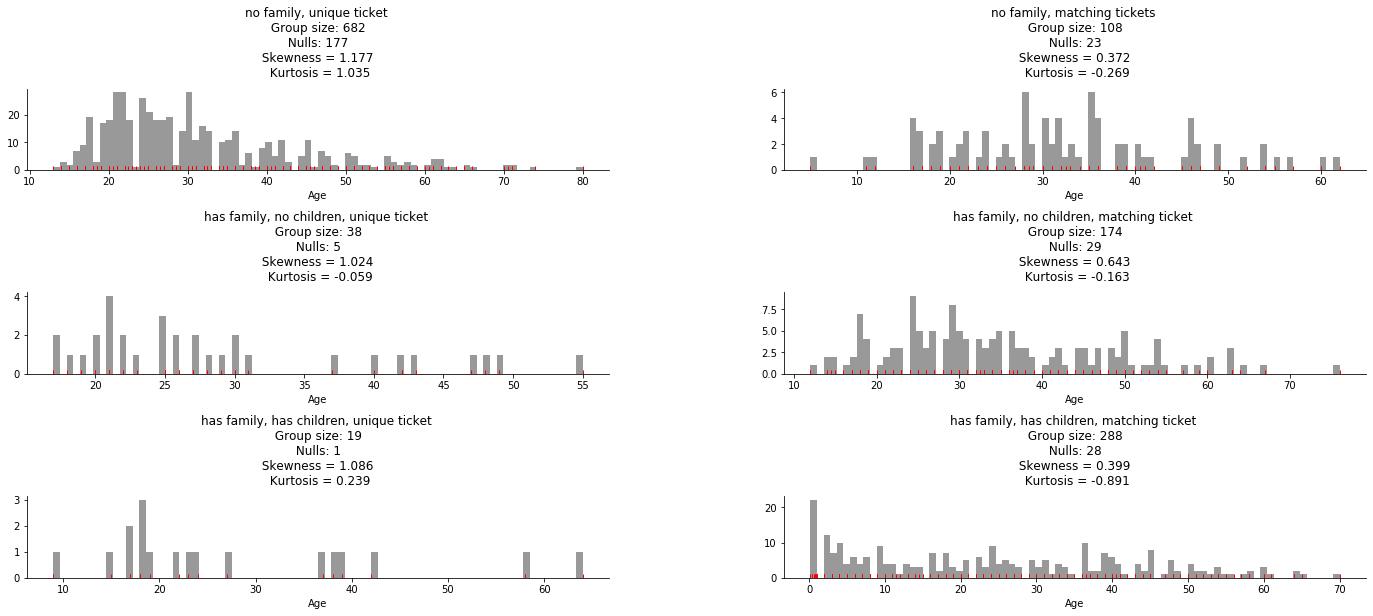

In [33]:
grd_cols_n = 2
grd_rows_n = 3

plt_h = 3
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Age Distribution by Family Groups', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=1.5)

for i, ttl in zip(enumerate(fam_grps), 
                   ['no family, unique ticket', 
                    'no family, matching tickets', 
                    'has family, no children, unique ticket', 
                    'has family, no children, matching ticket', 
                    'has family, has children, unique ticket', 
                    'has family, has children, matching ticket']):
    idx = i[0]
    df = i[1]
    nulls = df['Age'].isnull().sum()
    fig.add_subplot(gs[idx])
    df = df['Age'].dropna()
    ax = sns.distplot(df,
                 bins=80, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "0"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    grp_n = len(i[1].index)
    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    t = ax.title
    t.set_position([.5, 1.07])
    ax.set_title('{0} \n Group size: {1} \n Nulls: {2} \n Skewness = {3} \n Kurtosis = {4}'.format(ttl, grp_n, nulls, skewness, kurtosis))

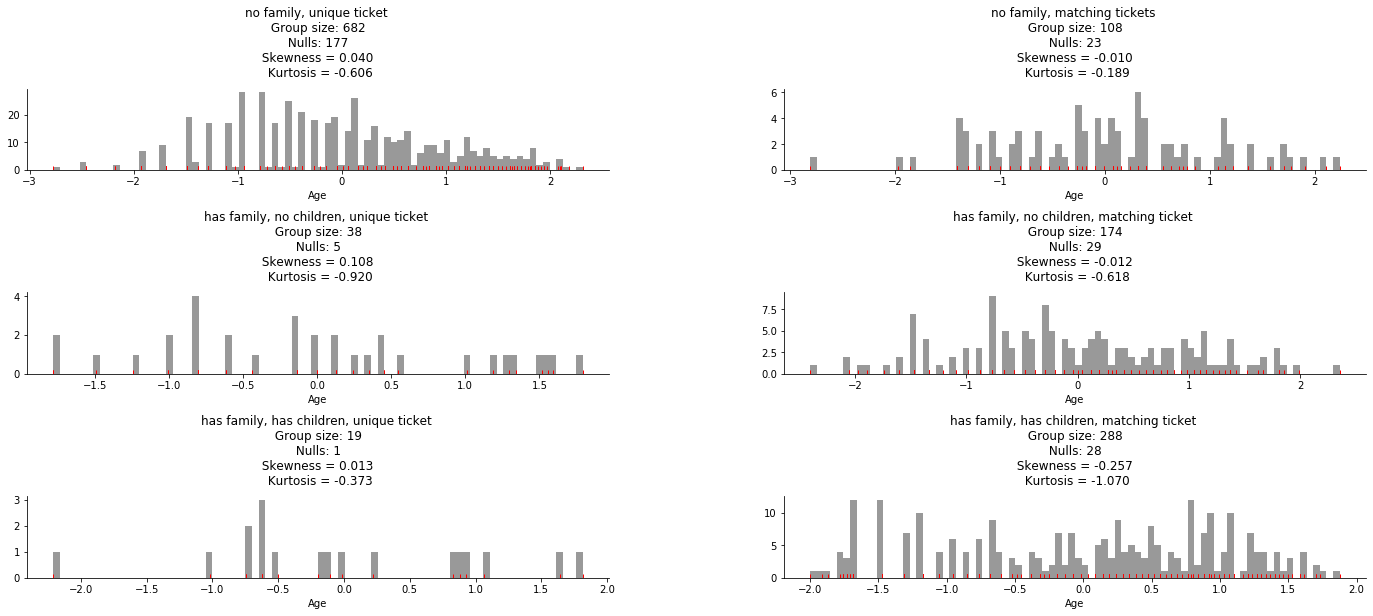

In [34]:
pt_age = prepc.PowerTransformer(method='box-cox', standardize=True)

grd_cols_n = 2
grd_rows_n = 3

plt_h = 3
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Age Distribution by Family Groups', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=1.5)

for i, ttl in zip(enumerate(fam_grps), 
                   ['no family, unique ticket', 
                    'no family, matching tickets', 
                    'has family, no children, unique ticket', 
                    'has family, no children, matching ticket', 
                    'has family, has children, unique ticket', 
                    'has family, has children, matching ticket']):
    idx = i[0]
    df = i[1]
    nulls = df['Age'].isnull().sum()
    fig.add_subplot(gs[idx])
    
    df = df['Age'].dropna()
    df = pt_age.fit_transform(np.array(df).reshape(-1,1))
    df = pd.Series(df.reshape(len(df)), name='Age')

    ax = sns.distplot(df,
                 bins=80, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "0"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    grp_n = len(i[1].index)
    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    t = ax.title
    t.set_position([.5, 1.07])
    ax.set_title('{0} \n Group size: {1} \n Nulls: {2} \n Skewness = {3} \n Kurtosis = {4}'.format(ttl, grp_n, nulls, skewness, kurtosis))
# print(tot_grps)
# print(len(data_tot.index))

In [35]:
#Encoding familie groups
def familie_groups_encoder(data, fam_grps):
    data['fgrp'] = 0
    for idx, grp in enumerate(fam_grps):
#         grp['fgrp'] = idx + 1
        for pid in grp['PassengerId']:
            data.loc[data['PassengerId']==pid, 'fgrp'] = idx + 1
    return data

In [36]:
#Encode 'Fare'
def fare_encoder(data, encode_grps):
    for grp in encode_grps:
        fare = grp['Fare'].values[0] / len(grp.index)
        grp['Fare'] = fare
        for pid in grp['PassengerId']:
            if pid in data['PassengerId']:
                data.loc[data['PassengerId']==pid, 'Fare'] = fare
    if len(data.loc[data['Fare'].isnull()])>0:
        for pid in data.loc[data['Fare'].isnull(), 'PassengerId']:
            c = data.loc[data['PassengerId']==pid, 'Pclass'].values[0]
            data.loc[data['PassengerId']==pid, 'Fare'] = np.mean(data.loc[data['Pclass']==c, 'Fare'])
    return data

In [37]:
#Encoding 'Sex'
def sex_encoder(data):
    mask = {'male':1, 'female':2}
    df = data['Sex'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['Sex']), df], axis=1)

In [38]:
#Adding 'Familie size'
def fam_size(data):
    data['famsize'] = data['SibSp'] + data['Parch'] + 1
    return data

In [39]:
data_tot = familie_groups_encoder(data_tot, fam_grps)
data_tot = fare_encoder(data_tot, [sig1, fam1, famch1])
data_tot = sex_encoder(data_tot)
data_tot = fam_size(data_tot)

In [40]:
data_tot

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,Cabin,lname0,lname1,ttl,Embarked,Ticket,fgrp,Sex,famsize
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.250000,NaN,Braund,,1,2,A521171,3,1,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,0.432471,C85,Cumings,Thayer,2,1,PC17599,4,2,2
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,7.925000,NaN,Heikkinen,,3,2,STONO23101282,1,2,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,0.432471,C123,Futrelle,Peel,2,2,113803,4,2,2
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,8.050000,NaN,Allen,,1,2,373450,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",NaN,0,0,8.050000,NaN,Spector,,1,2,A53236,1,1,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,108.900000,C105,Oliva y Ocana,,2,1,PC17758,1,2,1
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,7.250000,NaN,Saether,,1,2,SOTONOQ3101262,1,1,1
1307,1308,NaN,3,"Ware, Mr. Frederick",NaN,0,0,8.050000,NaN,Ware,,1,2,359309,1,1,1


### Preparing Data for 'Age' prediction

In [41]:
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        cv_res_sel.append(
            cv_res.loc[cv_res['rank_test_%s' % i] == 1, ['mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    #                 print(cv_res_sel)
    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean', 'std'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

In [42]:
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    cv_res = [[np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean', 'std'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

In [43]:
def base_models_predictions(models, X):
    X1 = None
    for i, model in models:
        if X1 is None:
            X1 = pd.Series(model.predict(X), name=i).to_frame()
        else:
            X1 = X1.merge(pd.Series(model.predict(X), name=i).to_frame(), left_index=True, right_index=True)
    return X1

In [44]:
data = data_tot[data_tot['Age'].notna()]
data = data[['Age', 'Fare', 'Pclass', 'Sex', 'ttl', 'fgrp', 'famsize', 'Embarked']]

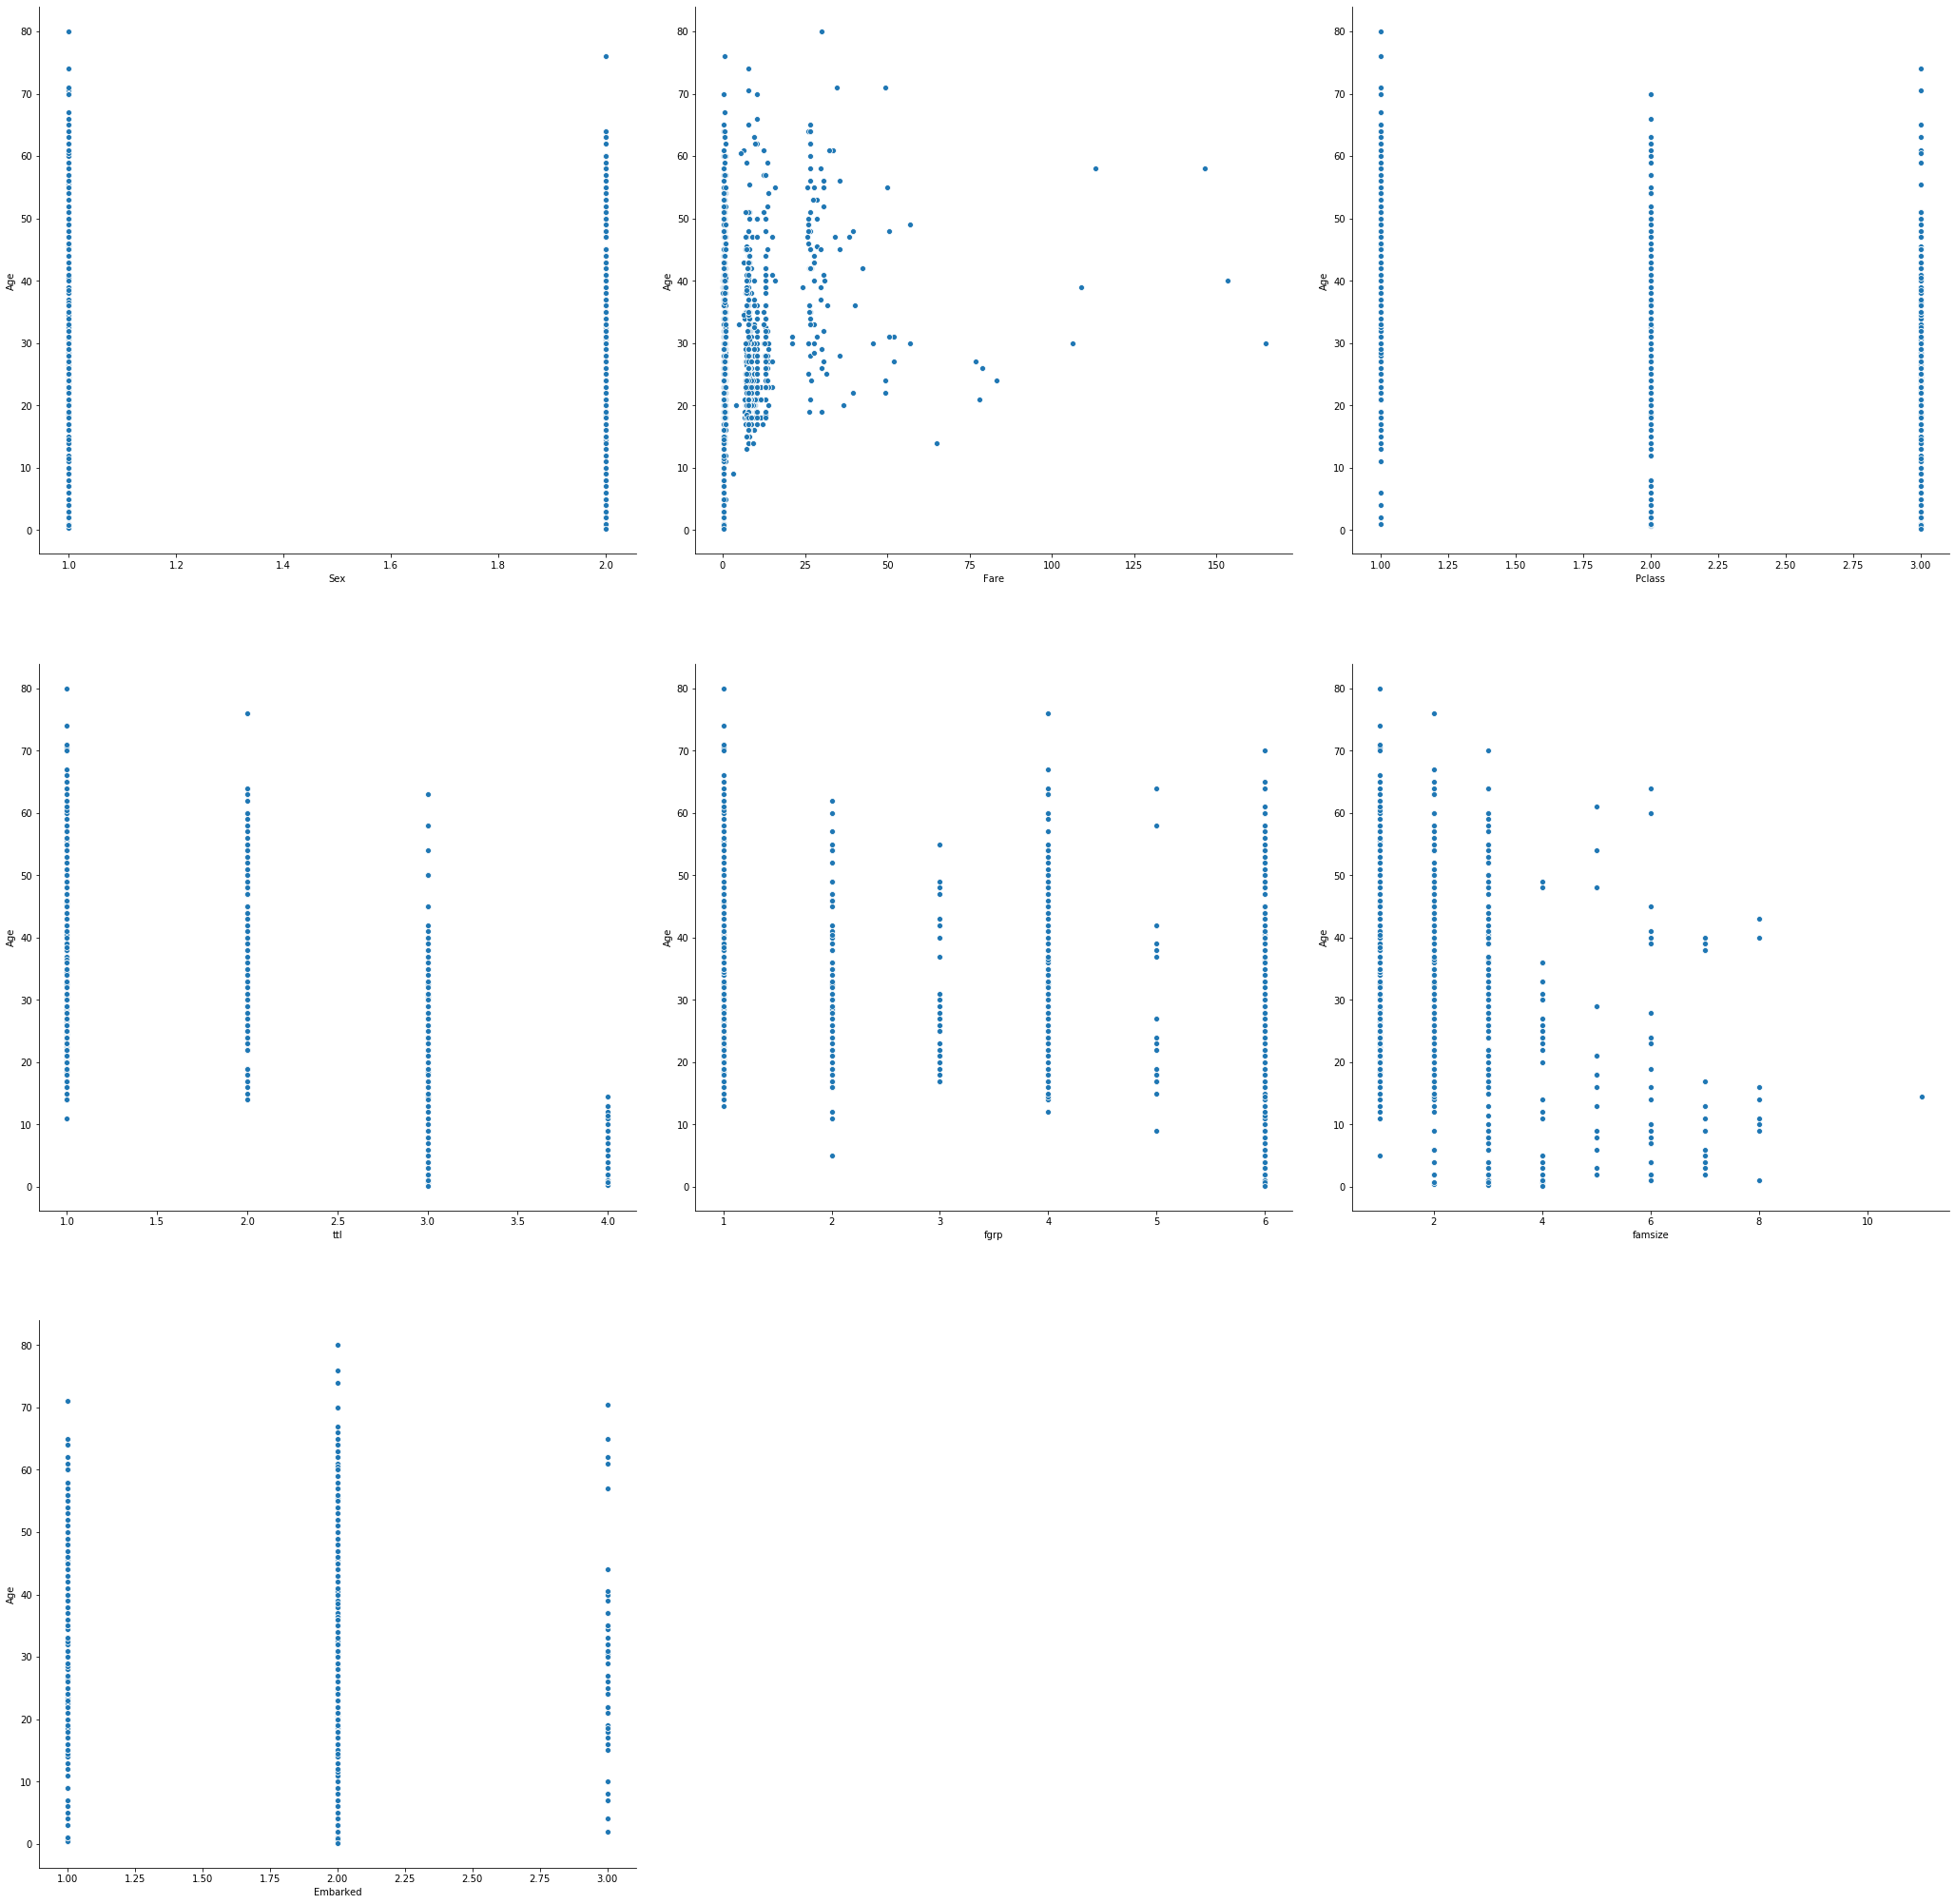

In [45]:
grd_cols_n = 3
grd_rows_n = 3

plt_h = 12
plt_w = 12

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.1, hspace=0.2)

for idx, i in enumerate(['Sex', 'Fare', 'Pclass', 'ttl', 'fgrp', 'famsize', 'Embarked']):
    fig.add_subplot(gs[idx])
    ax = sns.scatterplot(x=i, y='Age', data=data)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [46]:
#Transform 'Fare'
c = data['Fare'].apply(lambda i: np.log(i+1)).to_frame()
kbd = prepc.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
c = pd.DataFrame(kbd.fit_transform(np.array(c).reshape(-1,1)), columns=['Fare'])
data = pd.concat([data.drop(columns=['Fare']).reset_index(), c], axis=1).drop(columns='index')

In [47]:
#Transform 'Age'
c = pd.DataFrame(pt_age.fit_transform(np.array(data['Age']).reshape(-1,1)), columns=['Age'])
data = pd.concat([data.drop(columns=['Age']).reset_index(), c], axis=1).drop(columns='index')

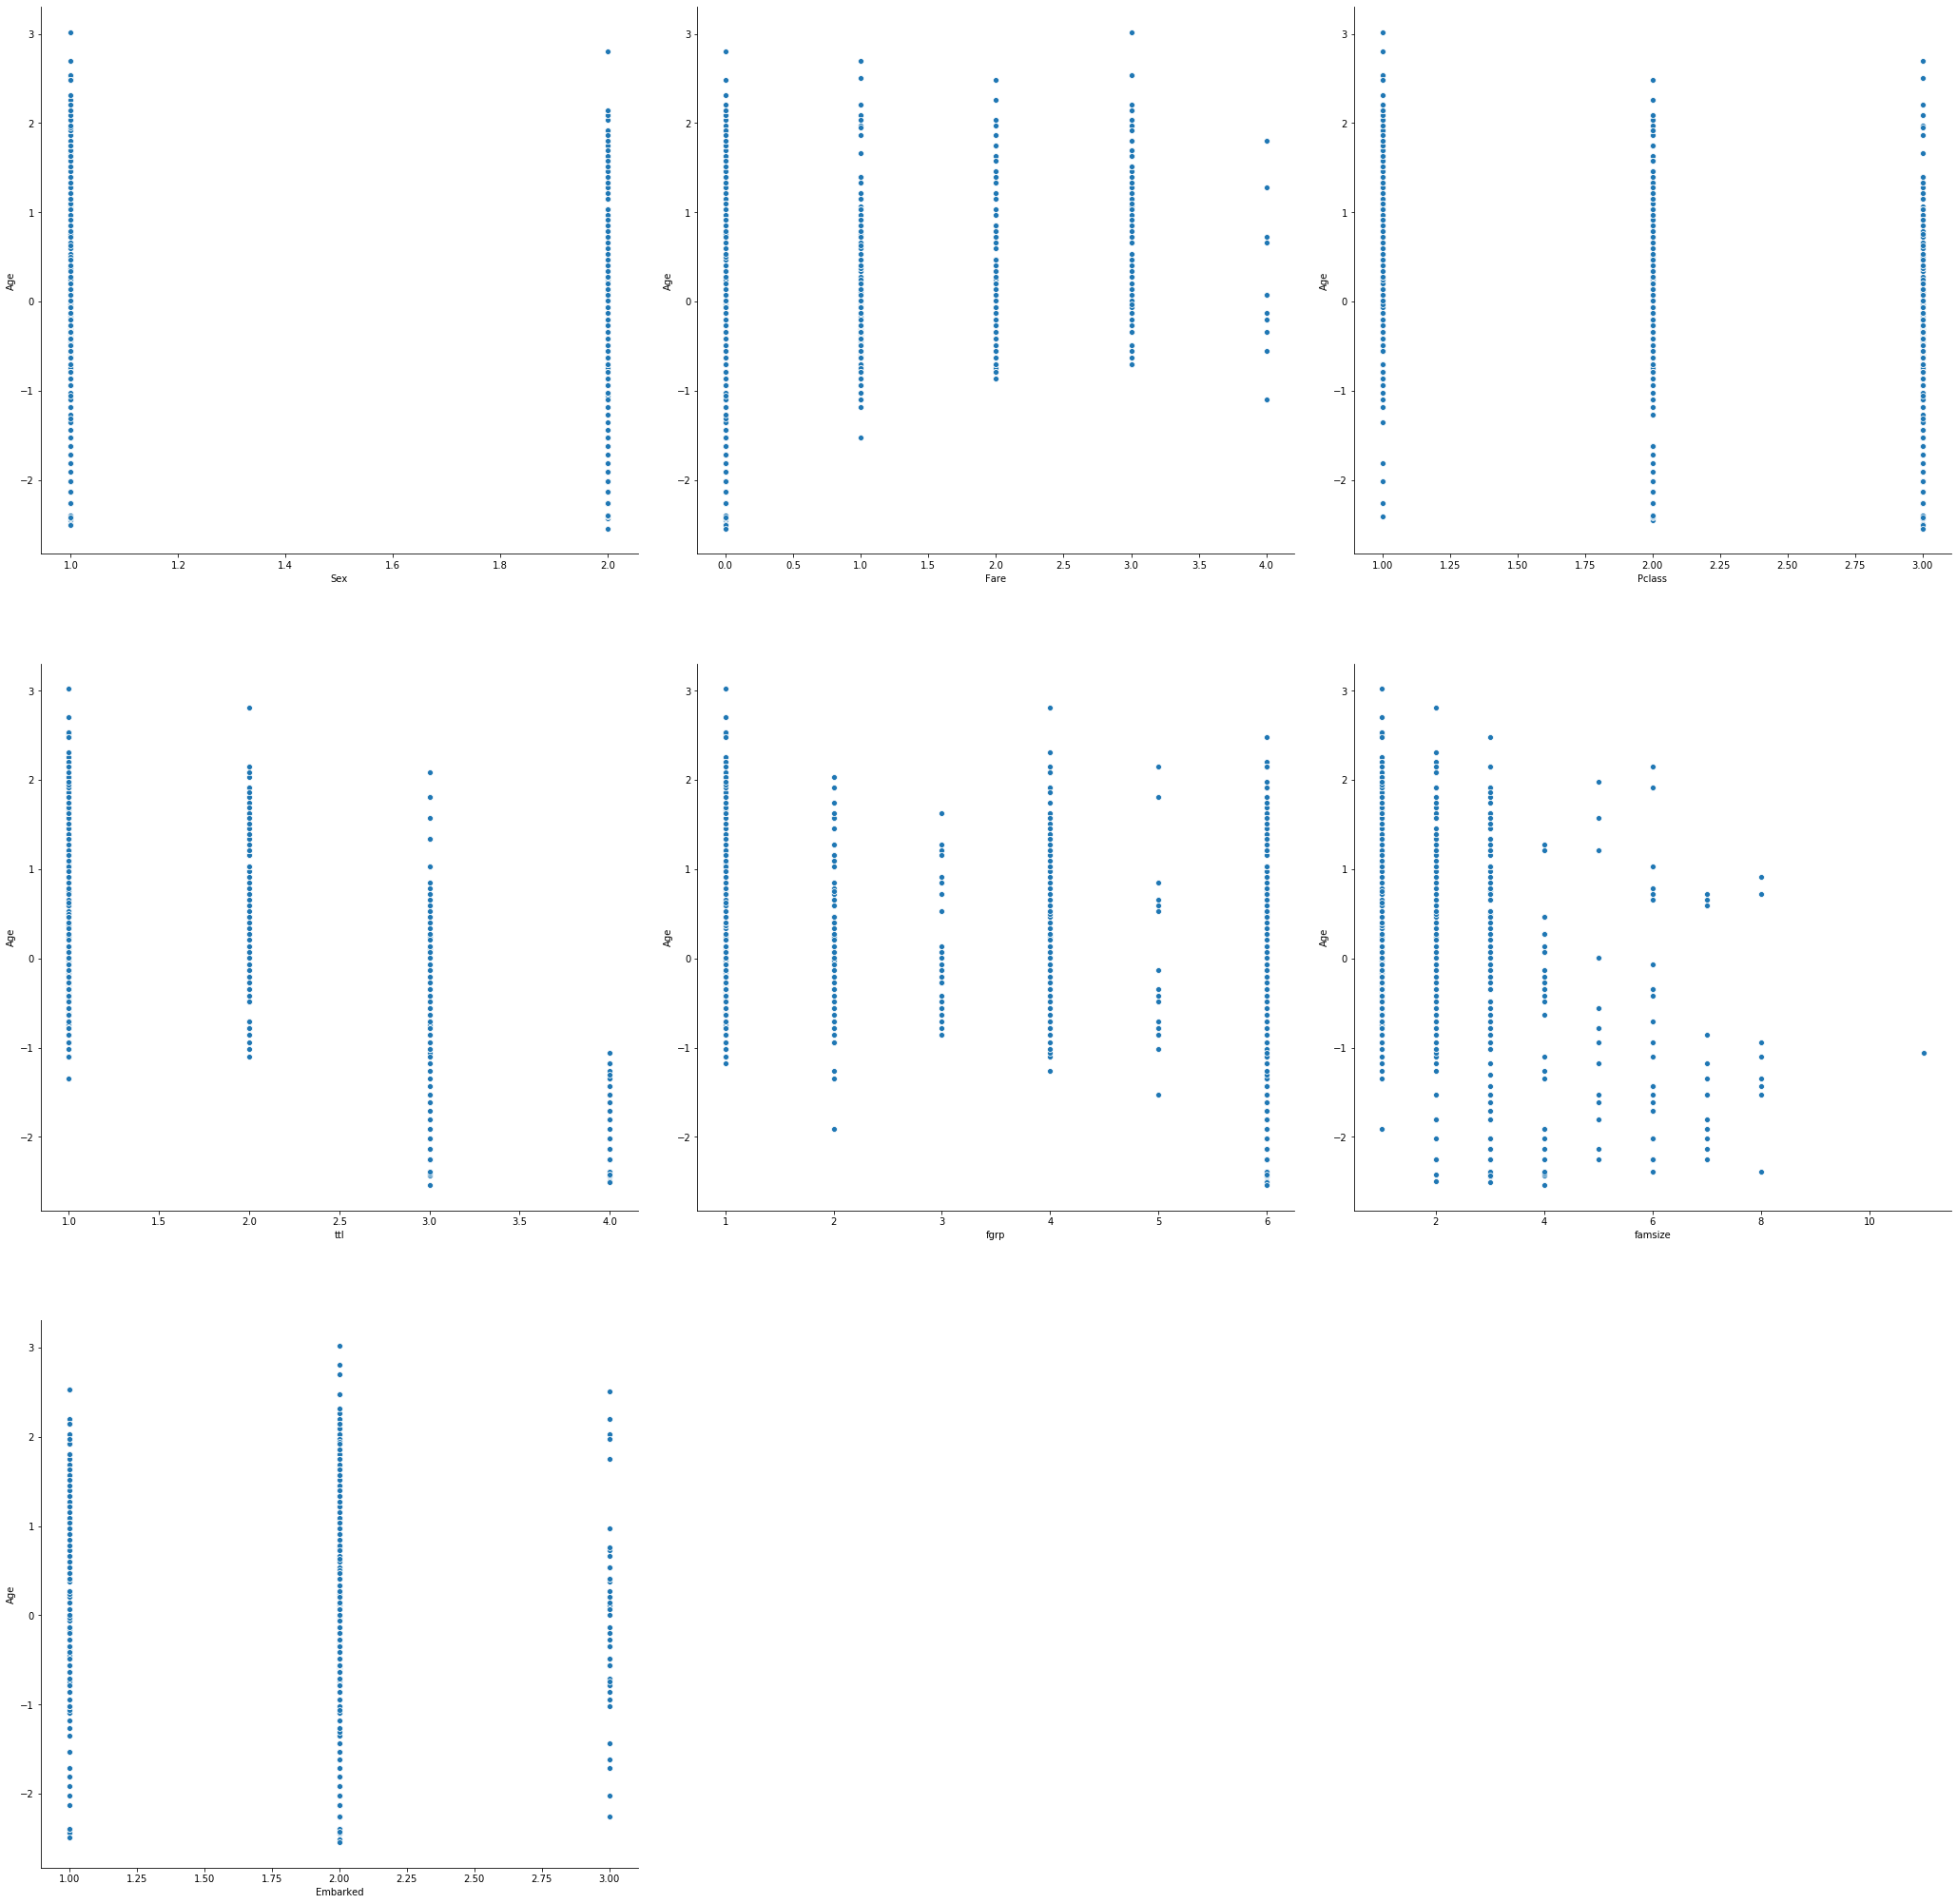

In [48]:
grd_cols_n = 3
grd_rows_n = 3

plt_h = 12
plt_w = 12

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.1, hspace=0.2)

for idx, i in enumerate(['Sex', 'Fare', 'Pclass', 'ttl', 'fgrp', 'famsize', 'Embarked']):
    fig.add_subplot(gs[idx])
    ax = sns.scatterplot(x=i, y='Age', data=data)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

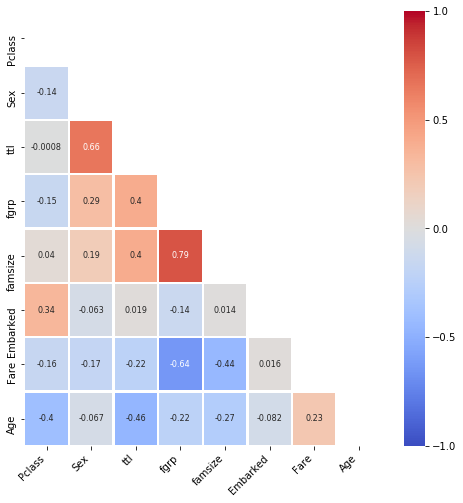

In [49]:
#plot correlation matrix
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
myplt.plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap='coolwarm')

In [50]:
def train_best_model(model, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    tes = metrics.r2_score(y_test, y_pred) 
    scores = [cv_res.loc['mean', refit],tes]
    print('Train set CV results \n {0} \n'.format(cv_res))
    print('Best parameters: {0} \n'.format(best_params))
    print('Test set score: {0}'.format(tes)) 
    return model, scores

In [51]:
def feature_importance(model, X_train, y_train, X_test, y_test, metric, label=None):
    feature_importance = dropcol_importances(model, X_train, y_train, X_valid=X_test, y_valid=y_test, metric=metric)
    if label is None:
        label = model.__class__.__name__
    feature_importance.columns = [label]
    return feature_importance

In [52]:
def dropcol_imp_r2_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.r2_score(y_valid, y_pred, sample_weight=sample_weights)

In [53]:
# train test split
# X = data.drop(columns=['Age', 'Sex', 'fgrp', 'Embarked'])
X = data.drop(columns=['Age'])
y = data['Age']

In [54]:
#Train/Test split
X_train, X_test, y_train, y_test =model_selection.train_test_split(X, y, test_size=0.1, shuffle=True, random_state=30)
#common random_state
random_state=30
#cross validation strategy
cv_folds = 5
# n_repeats = 10
cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.3, train_size=0.6, random_state=random_state)
#cross validation metrics
scoring = {'explained_variance':  'explained_variance',
           'r2': 'r2'}

#### Pipeline:

For all base estimators:
1. Initiate base estimator with base parameters
3. Tune parameters

For final estimator:

3. Get base estimators predictions
4. Tune final estimator parameters based on obtained base predictions

In [69]:
base_scores = {}

In [70]:
lsvr = svm.LinearSVR(epsilon=0.0, tol=0.01, loss='epsilon_insensitive', fit_intercept=True, random_state=random_state, max_iter=2000)
param_ranges = {'C': np.linspace(0.5, 2, 50), 'epsilon': np.linspace(0, 1, 15)}
lsvr, scores = train_best_model(lsvr, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit='r2')
base_scores['lsvr'] = scores

Train set CV results 
       explained_variance        r2
mean            0.432170  0.430120
std             0.028969  0.028691 

Best parameters: {'C': 1.7244897959183674, 'epsilon': 0.6428571428571428} 

Test set score: 0.5031506602820243


In [71]:
nusvr = svm.NuSVR(kernel='rbf', gamma='scale', shrinking=True, tol=0.001, max_iter=-1)
param_ranges = {'C': np.linspace(0.5, 2, 50), 'nu': np.linspace(0, 1, 15)}
nusvr, scores = train_best_model(nusvr, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit='r2')
base_scores['nusvr'] = scores

Train set CV results 
       explained_variance        r2
mean            0.464238  0.462012
std             0.031938  0.032505 

Best parameters: {'C': 2.0, 'nu': 0.42857142857142855} 

Test set score: 0.5647771672768256


In [72]:
svr = svm.SVR(kernel='rbf', gamma='scale', tol=0.001, shrinking=True, max_iter=-1)
param_ranges = {'C': np.linspace(0.5, 2, 50), 'epsilon': np.linspace(0.1, 1, 15)}
svr, scores = train_best_model(svr, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit='r2')
base_scores['svr'] = scores

Train set CV results 
       explained_variance        r2
mean            0.465810  0.463829
std             0.031439  0.031513 

Best parameters: {'C': 2.0, 'epsilon': 0.55} 

Test set score: 0.565743236767422


In [73]:
gpr = gaup.GaussianProcessRegressor(kernel=None, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, normalize_y=False, random_state=random_state)
param_ranges = {'n_restarts_optimizer': np.arange(0,4), 'alpha': np.linspace(1e-10, 1e-8, 15)}
gpr, scores = train_best_model(gpr, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit='r2')
base_scores['gpr'] = scores

Train set CV results 
       explained_variance        r2
mean            0.359515  0.357087
std             0.041506  0.043273 

Best parameters: {'alpha': 8.071428571428571e-10, 'n_restarts_optimizer': 0} 

Test set score: 0.49963805952108165


In [74]:
abr = ens.AdaBoostRegressor()
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'learning_rate': np.linspace(0.001, 0.1, 20), 'loss': ['exponential']}
abr, scores = train_best_model(abr, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit='r2')
base_scores['abr'] = scores

Train set CV results 
       explained_variance        r2
mean            0.485545  0.483785
std             0.015225  0.016849 

Best parameters: {'learning_rate': 0.05310526315789474, 'loss': 'exponential', 'n_estimators': 5} 

Test set score: 0.5621923053399442


In [75]:
bgr = ens.BaggingRegressor(random_state=random_state, n_jobs=-1)
param_ranges = {'n_estimators': np.arange(90, 200, 20), 'max_samples': np.arange(10, 500, 50)}
bgr, scores = train_best_model(bgr, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit='r2')
base_scores['bgr'] = scores

Train set CV results 
       explained_variance        r2
mean            0.489735  0.487736
std             0.012936  0.014188 

Best parameters: {'max_samples': 60, 'n_estimators': 190} 

Test set score: 0.5535210767245253


In [76]:
etr = ens.ExtraTreesRegressor(min_samples_split = 2, min_samples_leaf = 1, random_state=random_state, n_jobs=-1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etr, scores = train_best_model(etr, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit='r2')
base_scores['etr'] = scores

Train set CV results 
       explained_variance        r2
mean            0.497854  0.495916
std             0.021968  0.023176 

Best parameters: {'max_depth': 4, 'n_estimators': 25} 

Test set score: 0.5800273429581884


In [77]:
rfr = ens.RandomForestRegressor(min_samples_split = 2, min_samples_leaf = 1, random_state=random_state, n_jobs=-1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
rfr, scores = train_best_model(rfr, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit='r2')
base_scores['rfr'] = scores

Train set CV results 
       explained_variance        r2
mean            0.491908  0.489027
std             0.017853  0.018934 

Best parameters: {'max_depth': 3, 'n_estimators': 65} 

Test set score: 0.5696768076138707


In [78]:
rr = lm.Ridge(random_state=random_state)
param_ranges = {'alpha': np.linspace(0.01, 10, 20)}
rr, scores = train_best_model(rr, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit='r2')
base_scores['rr'] = scores

Train set CV results 
       explained_variance        r2
mean            0.431982  0.430688
std             0.027163  0.027119 

Best parameters: {'alpha': 7.371052631578948} 

Test set score: 0.49901496506327825


In [79]:
df = pd.DataFrame(base_scores, index=['train','test']).T
df = df.sort_values(by='test', ascending=False)
df

,train,test
etr,0.495916,0.580027
rfr,0.489027,0.569677
svr,0.463829,0.565743
nusvr,0.462012,0.564777
abr,0.483785,0.562192
bgr,0.487736,0.553521
lsvr,0.430120,0.503151
gpr,0.357087,0.499638
rr,0.430688,0.499015


In [80]:
base_models_age_dic = {'etr':etr,'rfr':rfr,'abr':abr,'bgr':bgr,'rr':rr,'lsvr':lsvr,'nusvr':nusvr,'svr':svr,'gpr':gpr}

In [81]:
base_models_age = [(k,base_models_age_dic[k]) for k in df.index]

In [82]:
# feature_importance_base = None
# for i, m in enumerate(base_models_age):
#     lbl, model = m
#     if lbl != 'bgr':
#         if feature_importance_base is None:
#             feature_importance_base = feature_importance(model, X_train, y_train, X_test, y_test, metric=dropcol_imp_r2_metric, label=lbl)
#         else:
#             feature_importance_base = feature_importance_base.merge(feature_importance(model, X_train, y_train, X_test, y_test, metric=dropcol_imp_r2_metric, label=lbl),
#                                                                         left_index=True, right_index=True)

In [83]:
# feature_importance_base.T.apply(np.mean).sort_values(ascending=False)

In [122]:
final_model_age = ens.StackingRegressor(estimators=base_models_age,
                                        final_estimator=svm.SVR(C=0.99, epsilon=0.4, kernel='rbf', gamma='scale', tol=0.001, shrinking=True, max_iter=-1),
                                        cv=model_selection.KFold(n_splits=5, shuffle=True, random_state=random_state),
                                        n_jobs=-1)
final_model_age.fit(X_train,y_train)
y_pred = final_model_age.predict(X_test) 
tes = metrics.r2_score(y_test, y_pred) 
print('Test set score: {0}'.format(tes)) 

Test set score: 0.5826793595789734


In [123]:
# final_model_age = ens.StackingRegressor(estimators=base_models_age,
#                                         final_estimator=ens.ExtraTreesRegressor(n_estimators=25, max_depth=4, random_state=random_state, n_jobs=-1),
#                                         cv=model_selection.KFold(n_splits=5, shuffle=True, random_state=random_state),
#                                         n_jobs=-1)
# final_model_age.fit(X_train,y_train)
# y_pred = final_model_age.predict(X_test) 
# tes = metrics.r2_score(y_test, y_pred) 
# print('Test set score: {0}'.format(tes)) 

In [124]:
def fare_transformer(data):
    c = data['Fare'].apply(lambda i: np.log(i+1)).to_frame()
    kbd = prepc.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
    c = pd.DataFrame(kbd.fit_transform(np.array(c).reshape(-1,1)), columns=['Fare'])
    c = c.astype(int)
    return pd.concat([data.drop(columns=['Fare']).reset_index(), c], axis=1).drop(columns='index')

In [125]:
def fare_transformer(data):
    c = data['Fare'].apply(lambda i: np.log(i+1)).to_frame()
    data = data.drop(columns='Fare')
    data = pd.concat([data, c], axis=1)
    kbd = prepc.KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='kmeans')
    c = pd.DataFrame(kbd.fit_transform(np.array(data['Fare']).reshape(-1,1)), columns=['Fare'])
    c = c.astype(int)
    return pd.concat([data.drop(columns=['Fare']).reset_index(), c], axis=1).drop(columns='index')

In [126]:
def age_transformer(data, transformer=None):
    if transformer is None:
        transformer = prepc.PowerTransformer()
    c = pd.DataFrame(pt_age.fit_transform(np.array(data['Age']).reshape(-1,1)), columns=['Age'])
    return pd.concat([data.drop(columns=['Age']).reset_index(), c], axis=1).drop(columns='index')

In [127]:
#Age encoder
def age_encoder(data, base_models_age, final_model_age):
    data = fare_transformer(data)
    data_na = data[data['Age'].isnull()]
    data_notna = data[data['Age'].notna()]
    #transform non-null age values
    data_notna = age_transformer(data_notna)
    #predict missing values
    y = pd.Series(final_model_age.predict(data_na[['Pclass', 'Sex', 'ttl', 'fgrp', 'famsize', 'Embarked', 'Fare']]), name='Age').to_frame()
    data_na = pd.concat([data_na.reset_index().drop(columns=['Age', 'index']), y], axis=1)
    return pd.concat([data_na, data_notna])

### Preprocess train set for classification

**Pipeline:**
1. Encode name
2. Encode title
3. Encode embarked
4. Encode familie groups
5. Encode fare
6. Encode sex
7. Add familie size
8. Encode age

In [128]:
data_train1 = name_encoder(data_train)
data_train1 = title_encoder(data_train1)
data_train1 = embarked_encoder(data_train1)
data_train1 = familie_groups_encoder(data_train1, fam_grps)
data_train1 = fare_encoder(data_train1, [sig1, fam1, famch1])
data_train1 = sex_encoder(data_train1)
data_train1 = fam_size(data_train1)
data_train1 = age_encoder(data_train1, base_models_age, final_model_age)

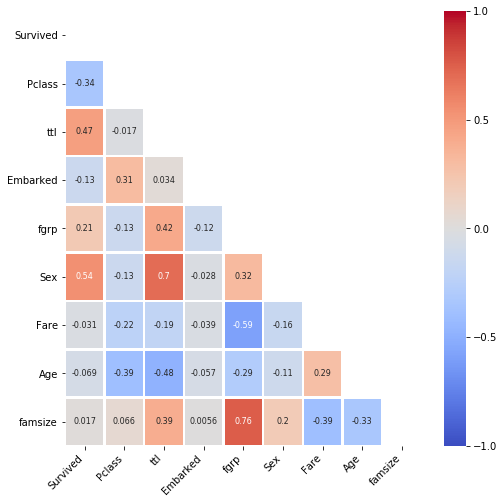

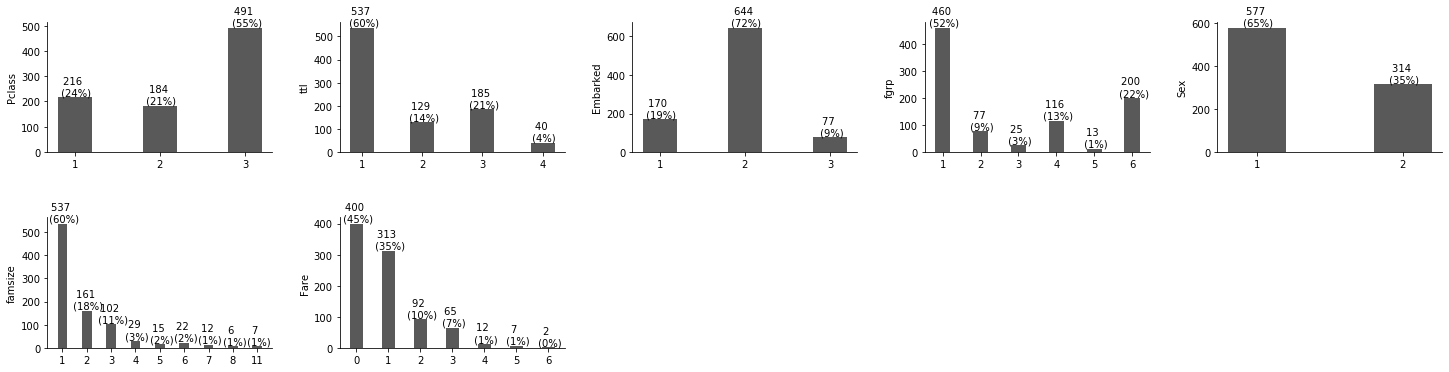

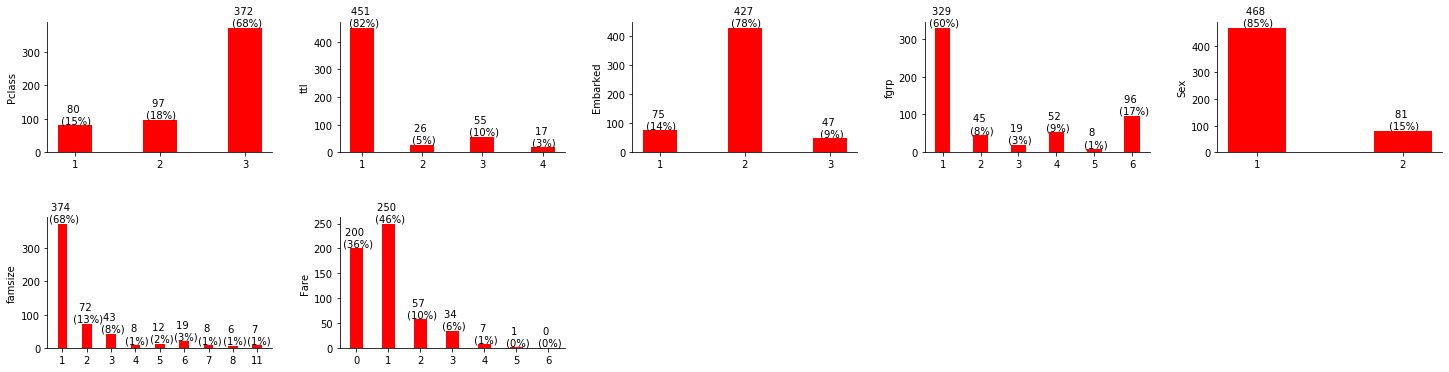

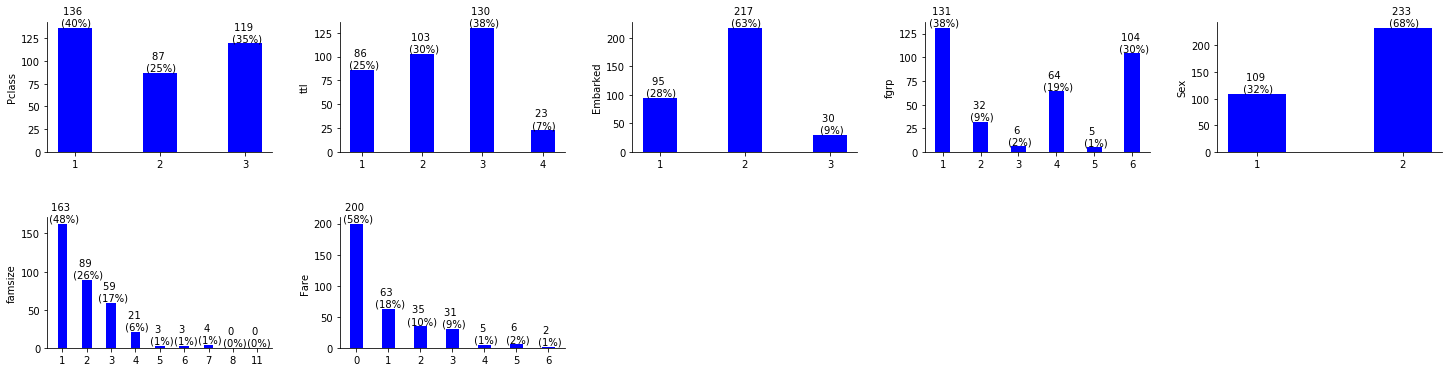

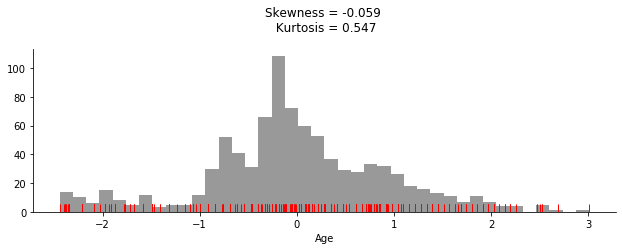

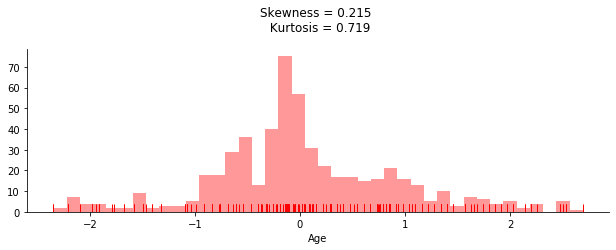

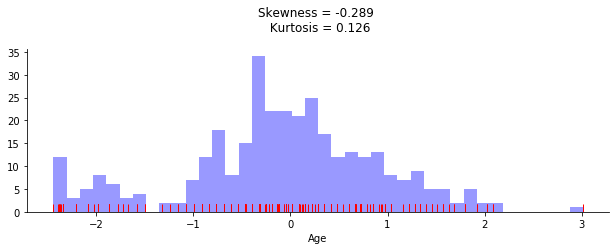

In [129]:
data = data_train1[['Survived','Pclass','ttl','Embarked','fgrp','Sex','Fare', 'Age', 'famsize']]
data_cat = data[['Pclass','ttl','Embarked','fgrp','Sex','famsize', 'Fare']]
data_num = data[['Age']]

#plot correlation matrix
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
myplt.plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap='coolwarm')


grd = list(data_cat.columns)
grd_n = len(grd)
grd_cols_n = 5
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 5

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n = len(data.loc[data[col]==i, col].index)
        fr = n / len(data.index)
        freq.append([n])
        frc.append([fr])

    df_freq = pd.DataFrame(freq, columns=['all'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['all'], index=data_cat[col].unique()).T
    labs = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['all'], df_frc.loc['all'])]
    myplt.plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs],
                           plots_labels=None,
                           plots_colors=['0.35'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (non-survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n0 = len(data.loc[(data['Survived']==0) & (data[col]==i), col].index)
        fr0 = n0 / N_surv0
        freq.append([n0])
        frc.append([fr0])

    df_freq = pd.DataFrame(freq, columns=['non_survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['non_survivals'], index=data_cat[col].unique()).T
    labs0 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['non_survivals'], df_frc.loc['non_survivals'])]
    myplt.plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs0],
                           plots_labels=None,
                           plots_colors=['r'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n1 = len(data.loc[(data['Survived']==1) & (data[col]==i), col].index)
        fr1 = n1 / N_surv1
        freq.append([n1])
        frc.append([fr1])

    df_freq = pd.DataFrame(freq, columns=['survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['survivals'], index=data_cat[col].unique()).T
    labs1 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['survivals'], df_frc.loc['survivals'])]
    myplt.plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs1],
                           plots_labels=None,
                           plots_colors=['b'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    

    
grd = list(data_num.columns)
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.7)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data[col].dropna()
    ax = sns.distplot(df,
                 bins=40, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "0"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (NON-SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.7)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==0, col].dropna()
    ax = sns.distplot(df,
                 bins=40, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "r"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.7)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==1, col].dropna()
    ax = sns.distplot(df,
                 bins=40, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))


In [130]:
def train_best_model(model, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    tes = metrics.roc_auc_score(y_test, y_pred, average='macro') 
    scores = [cv_res.loc['mean', refit],tes]
    print('Train set CV results \n {0} \n'.format(cv_res))
    print('Best parameters: {0} \n'.format(best_params))
    print('Test set score: {0}'.format(tes)) 
    return model, scores

In [131]:
def train_best_model_cal(model, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    model_cal.fit(X_train,y_train)
    y_pred = model_cal.predict(X_test)
    tes = metrics.roc_auc_score(y_test, y_pred, average='macro') 
    scores = [cv_res.loc['mean', refit],tes]
    print('Train set CV results \n {0} \n'.format(cv_res))
    print('Best parameters: {0} \n'.format(best_params))
    print('Test set score: {0}'.format(tes)) 
    return model_cal, scores

In [132]:
def dropcol_imp_roc_auc_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.roc_auc_score(y_valid, y_pred, sample_weight=sample_weights)

In [133]:
def dropcol_imp_accuracy_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.accuracy_score(y_valid, y_pred, sample_weight=sample_weights)

In [134]:
    def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
        """Plots confusion matrix
        Parameters:
        ax =  matplotlib axes
        normalyze = normalization over truth (number_predicted / total_count_of_this_class)
        """
        conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                                  labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
        classes = y.unique()
        classes.sort()
        n_classes = [len(y[y == c]) for c in classes]
        if normalize == True:
            n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
            norm_matrix = conf_matrix / np.array(n_classes)
            ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
            labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                                   ns_matrix[i, j]) for j, v in
                                enumerate(norm_matrix[i])]
                               for i, v in enumerate(norm_matrix)])

            sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
        else:
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        
        ax.set_ylabel('True Labels')
        ax.set_xlabel('Predicted Labels')
        if title is None:
            title = model.__class__.__name__
        ax.set_title(title)
        ttl = ax.title
        ttl.set_position([.5, 1.07])

        # fix for mpl bug that cuts off top/bottom of seaborn viz
        b, t = ax.get_ylim()  # discover the values for bottom and top
        b += 0.5  # Add 0.5 to the bottom
        t -= 0.5  # Subtract 0.5 from the top
        ax.set_ylim(b, t)  # update the ylim(bottom, top) values

In [135]:
def feature_importance(model, X_train, y_train, X_test, y_test, metric, label=None):
    feature_importance = dropcol_importances(model, X_train, y_train, X_valid=X_test, y_valid=y_test, metric=metric)
    if label is None:
        label = model.__class__.__name__
    feature_importance.columns = [label]
    return feature_importance

In [136]:
def base_models_predictions_proba(models, X):
    X0 = None
    X1 = None
    for i, model in models:
#         print(model.predict_proba(X))
        proba_0 = model.predict_proba(X)[:,0]
        proba_1 = model.predict_proba(X)[:,1]
#         print(proba_0)
        if X0 is None:
            X0 = pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame()
        else:
            X0 = X0.merge(pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
        
        if X1 is None:
            X1 = pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame()
        else:
            X1 = X1.merge(pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
    return (X0, X1)

In [137]:
def train_best_model(model, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    tes = metrics.roc_auc_score(y_test, y_pred, average='macro') 
    scores = [cv_res.loc['mean', refit],tes]
    print('Train set CV results \n {0} \n'.format(cv_res))
    print('Best parameters: {0} \n'.format(best_params))
    print('Test set score: {0}'.format(tes)) 
    return model, scores

In [138]:
# train test split
X = data.drop(columns=['Survived', 'ttl', 'famsize'])
y = data['Survived'] #.apply(lambda i: -1 if i==0 else 1)

In [174]:
#Train/Test split
X_train, X_test, y_train, y_test =model_selection.train_test_split(X, y, test_size=0.1, random_state=30)
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=None, random_state=random_state)
#cross validation metrics
scoring = {'roc_auc':  'roc_auc',
           'accuracy': 'accuracy',
           'precision_macro': 'precision_macro'}
refit = 'accuracy'

In [175]:
base_scores = {}

In [176]:
# class_weight='balanced'
class_weight={0:0.62,1:0.38}

In [249]:
gpc.get_params().keys()

dict_keys(['cv', 'estimator__copy_X_train', 'estimator__kernel', 'estimator__max_iter_predict', 'estimator__multi_class', 'estimator__n_jobs', 'estimator__n_restarts_optimizer', 'estimator__optimizer', 'estimator__random_state', 'estimator__warm_start', 'estimator', 'min_features_to_select', 'n_jobs', 'scoring', 'step', 'verbose'])

In [250]:
gpc = gaup.GaussianProcessClassifier(kernel=None, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, random_state=random_state)
gpc = feature_selection.RFECV(gpc, step=1, scoring='accuracy', cv=cv, n_jobs=-1)

param_ranges = {'estimator__max_iter_predict': np.arange(100, 200, 10)}
gpc, scores = train_best_model(gpc, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
base_scores['gpc'] = scores

RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [178]:
lda = disan.LinearDiscriminantAnalysis(solver='svd', shrinkage=None)
param_ranges = {'base_estimator__n_components': np.arange(1,10)}
lda, scores = train_best_model_cal(lda, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
base_scores['lda'] = scores

Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.845607  0.790062         0.779733
std   0.016848  0.020563         0.023126 

Best parameters: {'base_estimator__n_components': 1} 

Test set score: 0.8082610912799593


In [179]:
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_weight[0], class_weight[1]])
# qda = disan.QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0, store_covariance=False, tol=0.0001)
param_ranges = {'base_estimator__reg_param': np.linspace(0.01,1,12)}
qda, scores = train_best_model_cal(qda, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
base_scores['qda'] = scores

Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.853016  0.792547         0.785204
std   0.017771  0.014487         0.018437 

Best parameters: {'base_estimator__reg_param': 0.01} 

Test set score: 0.8312085670576237


In [180]:
abc = ens.AdaBoostClassifier(algorithm='SAMME.R', random_state=random_state)
param_ranges = {'base_estimator__n_estimators': np.arange(5, 100, 20), 'base_estimator__learning_rate': np.linspace(0.001, 0.1, 20)}
abc, scores = train_best_model_cal(abc, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
base_scores['abc'] = scores

Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.851180  0.803727         0.793631
std   0.016575  0.027102         0.028887 

Best parameters: {'base_estimator__learning_rate': 0.1, 'base_estimator__n_estimators': 85} 

Test set score: 0.8447220805711373


In [181]:
# bgc = ens.BaggingClassifier(random_state=random_state, n_jobs=-1)
# param_ranges = {'base_estimator__n_estimators': np.arange(100, 200, 5), 'base_estimator__max_samples': np.arange(10, 500, 10)}
# bgc, scores = train_best_model_cal(bgc, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
# base_scores['bgc'] = scores

In [182]:
gbc = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                     min_samples_split=2, min_samples_leaf=1,
                                     init=None, random_state=random_state, 
                                     max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', 
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
param_ranges = {'base_estimator__learning_rate': np.linspace(0.01, 0.2, 10), 'base_estimator__n_estimators': np.arange(5, 100, 20)}
gbc, scores = train_best_model_cal(gbc, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)

param_ranges = {'base_estimator__subsample': np.linspace(0.1, 1.1, 15), 'base_estimator__max_depth': np.arange(3, 6)}
gbc, scores = train_best_model_cal(gbc, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)

param_ranges = {'base_estimator__min_weight_fraction_leaf': np.linspace(0.01, 0.2, 10), 'base_estimator__min_impurity_decrease': np.linspace(0.01, 0.2, 15)}
gbc, scores = train_best_model_cal(gbc, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)

base_scores['gbc'] = scores

Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.864721  0.817391         0.818613
std   0.022561  0.024720         0.028846 

Best parameters: {'base_estimator__learning_rate': 0.052222222222222225, 'base_estimator__n_estimators': 85} 

Test set score: 0.8447220805711373
Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.869049  0.816149         0.817113
std   0.025016  0.027102         0.037302 

Best parameters: {'base_estimator__max_depth': 5, 'base_estimator__subsample': 0.17142857142857143} 

Test set score: 0.8541560428352881
Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.870230  0.822360         0.820026
std   0.023572  0.022082         0.025515 

Best parameters: {'base_estimator__min_impurity_decrease': 0.18642857142857144, 'base_estimator__min_weight_fraction_leaf': 0.09444444444444444} 

Test set score: 0.8635900050994391


In [183]:
etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'base_estimator__n_estimators': np.arange(5, 100, 20),
                'base_estimator__max_depth': np.arange(3, 10)}
etc, scores = train_best_model_cal(etc, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
base_scores['etc'] = scores

Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.868328  0.824845         0.823771
std   0.026496  0.024658         0.019511 

Best parameters: {'base_estimator__max_depth': 9, 'base_estimator__n_estimators': 85} 

Test set score: 0.8082610912799593


In [184]:
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'base_estimator__n_estimators': np.arange(5, 100, 20),
                'base_estimator__max_depth': np.arange(5, 10)}
rfc, scores = train_best_model_cal(rfc, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
base_scores['rfc'] = scores

Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.868607  0.822360         0.824014
std   0.027931  0.022082         0.031389 

Best parameters: {'base_estimator__max_depth': 5, 'base_estimator__n_estimators': 5} 

Test set score: 0.8312085670576237


In [185]:
lr = lm.LogisticRegression(class_weight=class_weight, random_state=random_state, n_jobs=-1)
param_ranges = {'base_estimator__C': np.linspace(0.01, 5, 20)}
lr, scores = train_best_model_cal(lr, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
base_scores['lr'] = scores

Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.846098  0.796273         0.785836
std   0.014021  0.014380         0.015709 

Best parameters: {'base_estimator__C': 3.6868421052631577} 

Test set score: 0.8217746047934728


In [186]:
pac = lm.PassiveAggressiveClassifier(class_weight=class_weight, random_state=random_state, n_jobs=-1)
param_ranges = {'base_estimator__C': np.linspace(0.01, 1, 20)}
pac, scores = train_best_model_cal(pac, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
base_scores['pac'] = scores

Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.847607  0.796273         0.786331
std   0.022207  0.025879         0.029649 

Best parameters: {'base_estimator__C': 0.06210526315789474} 

Test set score: 0.7771545130035696


In [187]:
rc = lm.RidgeClassifier(class_weight=class_weight, random_state=random_state, solver='auto')
param_ranges = {'base_estimator__alpha': np.linspace(0.01, 40, 20)}
rc, scores = train_best_model_cal(rc, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
base_scores['rc'] = scores

Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.846393  0.793789         0.783929
std   0.016279  0.023040         0.026298 

Best parameters: {'base_estimator__alpha': 0.01} 

Test set score: 0.8082610912799593


In [188]:
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weight)
param_ranges = {'base_estimator__C': np.linspace(0.01, 10, 20)}
svc, scores = train_best_model_cal(svc, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
base_scores['svc'] = scores

Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.844000  0.821118         0.827594
std   0.013891  0.021300         0.024828 

Best parameters: {'base_estimator__C': 6.845263157894737} 

Test set score: 0.8365629780724121


In [189]:
lsvc = svm.LinearSVC(penalty='l2', loss='squared_hinge', class_weight=class_weight, max_iter=1500, tol=0.05)
param_ranges = {'base_estimator__C': np.linspace(0.005, 1, 20)}
lsvc, scores = train_best_model_cal(lsvc, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
base_scores['lsvc'] = scores

Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.845869  0.793789         0.783592
std   0.013761  0.014907         0.018132 

Best parameters: {'base_estimator__C': 0.21447368421052632} 

Test set score: 0.8176950535441102


In [190]:
nusvc = svm.NuSVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weight)
param_ranges = {'base_estimator__nu': np.linspace(0.1,1,10)}
nusvc, scores = train_best_model_cal(nusvc, param_ranges, X_train, y_train, X_test, y_test, scoring, cv, refit=refit)
base_scores['nusvc'] = scores

Train set CV results 
        roc_auc  accuracy  precision_macro
mean  0.858885  0.824845         0.822745
std   0.026295  0.014380         0.018619 

Best parameters: {'base_estimator__nu': 0.5} 

Test set score: 0.8082610912799593


In [191]:
df = pd.DataFrame(base_scores, index=['train','test']).T
df = df.sort_values(by='test', ascending=False)
df

,train,test
gbc,0.822360,0.863590
abc,0.803727,0.844722
svc,0.821118,0.836563
qda,0.792547,0.831209
rfc,0.822360,0.831209
lr,0.796273,0.821775
lsvc,0.793789,0.817695
gpc,0.808696,0.816420
lda,0.790062,0.808261
etc,0.824845,0.808261


In [192]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'rc':rc,'svc':svc,'lsvc':lsvc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [193]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in df.index]

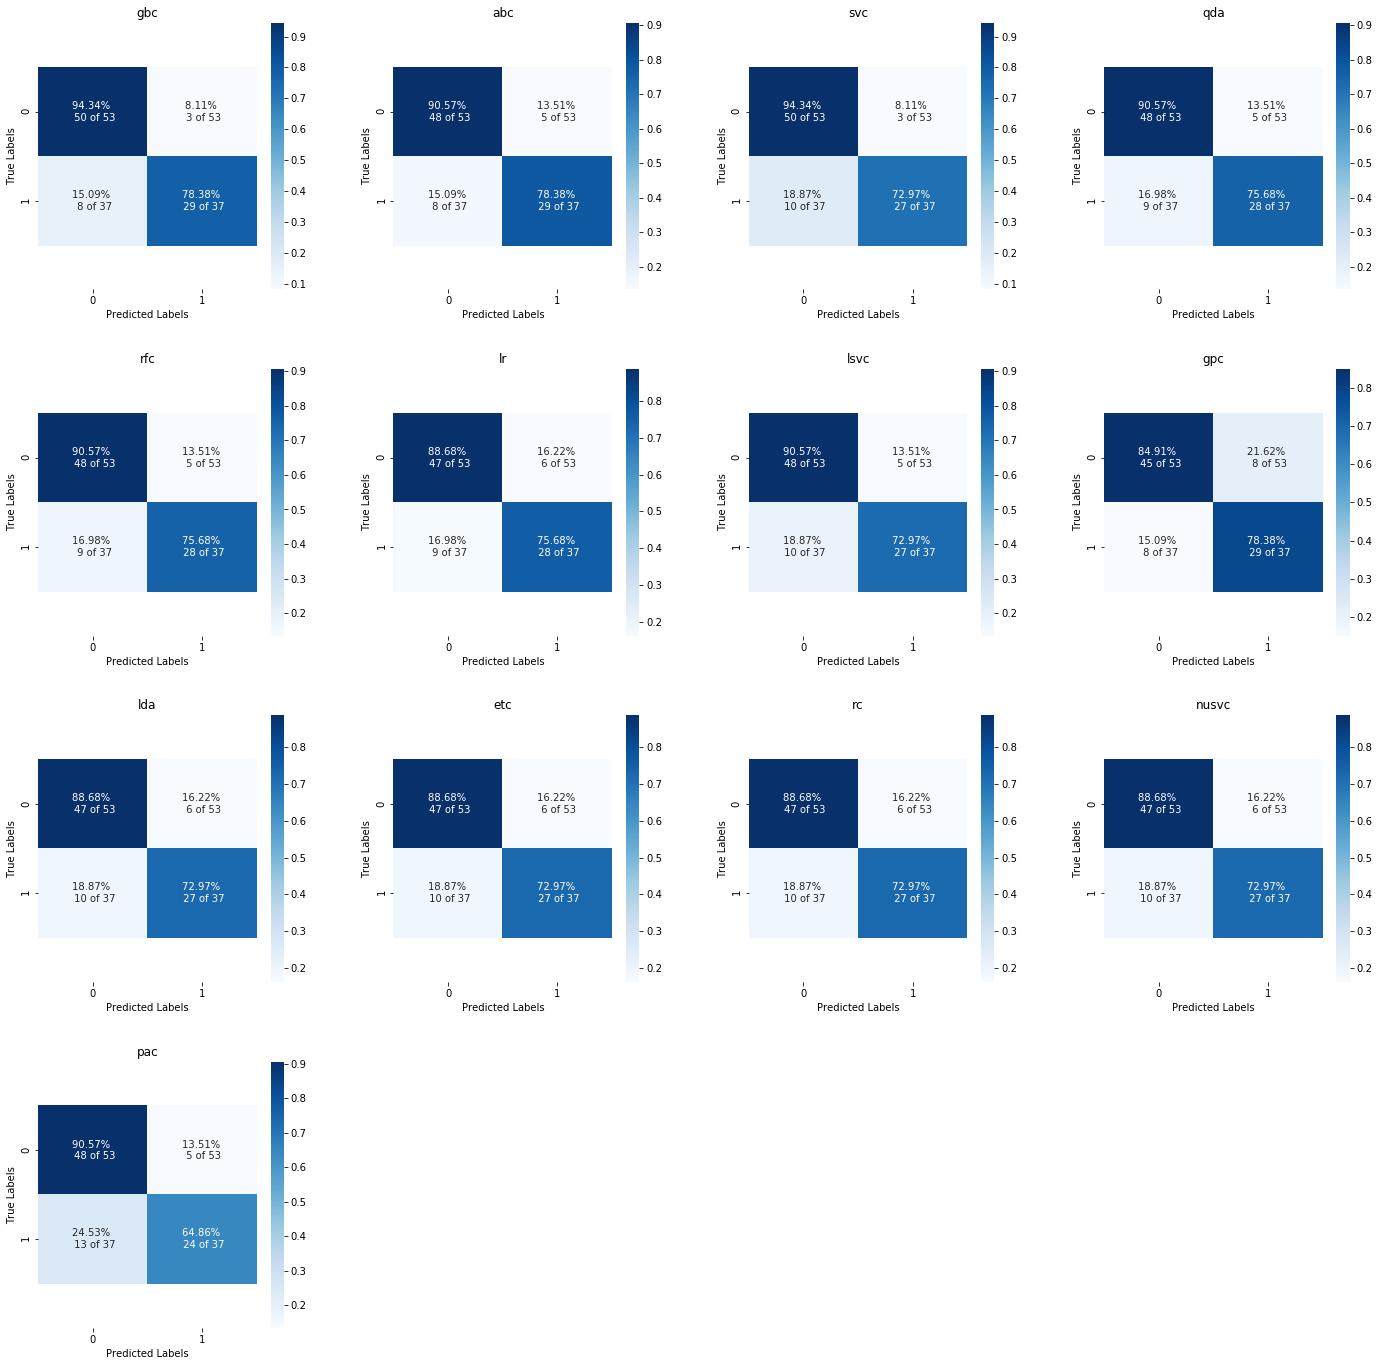

In [194]:
grd_n = len(base_models_surv)
grd_cols_n = 4
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(6 * grd_cols_n, 6 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X_test, y_test, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [222]:
# final_estimator = disan.LinearDiscriminantAnalysis(solver='svd', shrinkage=None)
# final_estimator = calib.CalibratedClassifierCV(base_estimator=final_estimator, method='sigmoid', cv=cv)
# # params = gbc.get_params()
# # final_estimator = final_estimator.set_params(**params)
# fin_lda = ens.StackingClassifier(estimators=base_models_surv,
#                                              final_estimator=final_estimator,
#                                         cv=5, stack_method='predict', n_jobs=-1)
# fin_lda.fit(X_train,y_train)
# y_pred = fin_lda.predict(X_test) 
# tes = metrics.accuracy_score(y_test, y_pred) 
# print('Test set score: {0}'.format(tes)) 

Test set score: 0.8555555555555555


In [195]:
# final_estimator = gaup.GaussianProcessClassifier(kernel=None, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, random_state=random_state)
# final_estimator = calib.CalibratedClassifierCV(base_estimator=final_estimator, method='sigmoid', cv=cv)
# # params = gbc.get_params()
# # final_estimator = final_estimator.set_params(**params)
# fin_gaup = ens.StackingClassifier(estimators=base_models_surv,
#                                              final_estimator=final_estimator,
#                                         cv=5, stack_method='predict', n_jobs=-1)
# fin_gaup.fit(X_train,y_train)
# y_pred = fin_gaup.predict(X_test) 
# tes = metrics.accuracy_score(y_test, y_pred) 
# print('Test set score: {0}'.format(tes)) 

Test set score: 0.8444444444444444


In [196]:
# final_estimator = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
#                                                      learning_rate=0.1, n_estimators=25,
#                                                      max_depth=3, subsample=0.81,
#                                                      min_impurity_decrease=0.09444,
#                                                      min_weight_fraction_leaf=0.09444,
#                                                  min_samples_split=2, min_samples_leaf=1,
#                                                  random_state=random_state, 
#                                                  max_features=None, verbose=0, max_leaf_nodes=None, 
#                                                  validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
# final_estimator = calib.CalibratedClassifierCV(base_estimator=final_estimator, method='sigmoid', cv=cv)
# # params = gbc.get_params()
# # final_estimator = final_estimator.set_params(**params)
# fin_gbc = ens.StackingClassifier(estimators=base_models_surv,
#                                              final_estimator=final_estimator,
#                                         cv=5, stack_method='predict', n_jobs=-1)
# fin_gbc.fit(X_train,y_train)
# y_pred = fin_gbc.predict(X_test) 
# tes = metrics.accuracy_score(y_test, y_pred) 
# print('Test set score: {0}'.format(tes)) 

Test set score: 0.8444444444444444


In [197]:
# final_estimator = svm.SVC(C=6.3195, kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weight)
# final_estimator = calib.CalibratedClassifierCV(base_estimator=final_estimator, method='sigmoid', cv=cv)
# # params = svc.get_params()
# # final_estimator = final_estimator.set_params(**params)
# fin_svc = ens.StackingClassifier(estimators=base_models_surv,
#                                              final_estimator=final_estimator,
#                                         cv=5, stack_method='predict', n_jobs=-1)
# fin_svc.fit(X_train,y_train)
# y_pred = fin_svc.predict(X_test) 
# tes = metrics.accuracy_score(y_test, y_pred) 
# print('Test set score: {0}'.format(tes)) 

Test set score: 0.8444444444444444


In [220]:
# final_estimator = ens.AdaBoostClassifier(algorithm='SAMME.R', random_state=random_state,
#                                          learning_rate=0.03,
#                                          n_estimators=85)
# final_estimator = calib.CalibratedClassifierCV(base_estimator=final_estimator, method='sigmoid', cv=cv)
# # params = abc.get_params()
# # final_estimator = final_estimator.set_params(**params)
# fin_abc = ens.StackingClassifier(estimators=base_models_surv,
#                                              final_estimator=final_estimator,
#                                         cv=5, stack_method='predict', n_jobs=-1)
# fin_abc.fit(X_train,y_train)
# y_pred = fin_abc.predict(X_test) 
# tes = metrics.accuracy_score(y_test, y_pred) 
# print('Test set score: {0}'.format(tes)) 

Test set score: 0.8555555555555555


In [246]:
final_estimator = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               min_samples_split=2,
                               min_samples_leaf=1,
                                max_depth=4,
                                          n_estimators=5)
# final_estimator.fit(X_train,y_train)
# final_estimator = feature_selection.RFECV(final_estimator, step=1, scoring='accuracy', cv=cv, n_jobs=-1)
final_estimator = calib.CalibratedClassifierCV(base_estimator=final_estimator, method='sigmoid', cv=cv)

# params = etc.get_params()
# final_estimator = final_estimator.set_params(**params)
fin_etc = ens.StackingClassifier(estimators=base_models_surv,
                                             final_estimator=final_estimator,
                                        cv=5, stack_method='predict', n_jobs=-1)
# fin_etc = feature_selection.RFECV(fin_etc, step=1, scoring='accuracy', cv=cv, n_jobs=-1)
fin_etc.fit(X_train,y_train)
y_pred = fin_etc.predict(X_test) 
tes = metrics.accuracy_score(y_test, y_pred) 
print('Test set score: {0}'.format(tes)) 

Test set score: 0.8666666666666667


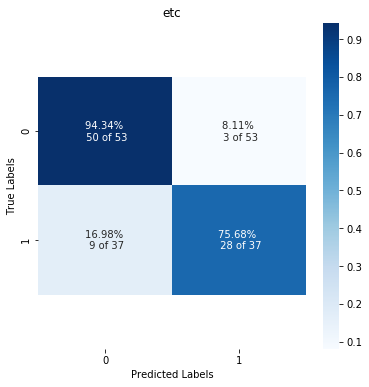

In [236]:
fig = plt.figure()
fig.set_size_inches(6,6)
plot_confusion_matrix(fin_etc, X_test, y_test, ax=fig.add_subplot(1,1,1), normalize=True, title='etc')

In [232]:
# final_models_surv = (('gbc', fin_gbc), ('svc', fin_svc), ('abc', fin_abc), ('etc', fin_etc), ('fin_gaup', fin_gaup), ('fin_lda', fin_lda))

In [233]:
# weights = [1, 1, 1, 10.9, 1.1, 1]

In [234]:
# final_model_surv_vt = ens.VotingClassifier(estimators=final_models_surv,
#                                         voting='soft', weights=weights,
#                                            n_jobs=-1, flatten_transform=False)
# final_model_surv_vt.fit(X_train,y_train)
# y_pred = final_model_surv_vt.predict(X_test) 
# tes = metrics.accuracy_score(y_test, y_pred) 
# print('Test set score: {0}'.format(tes)) 

Test set score: 0.8666666666666667


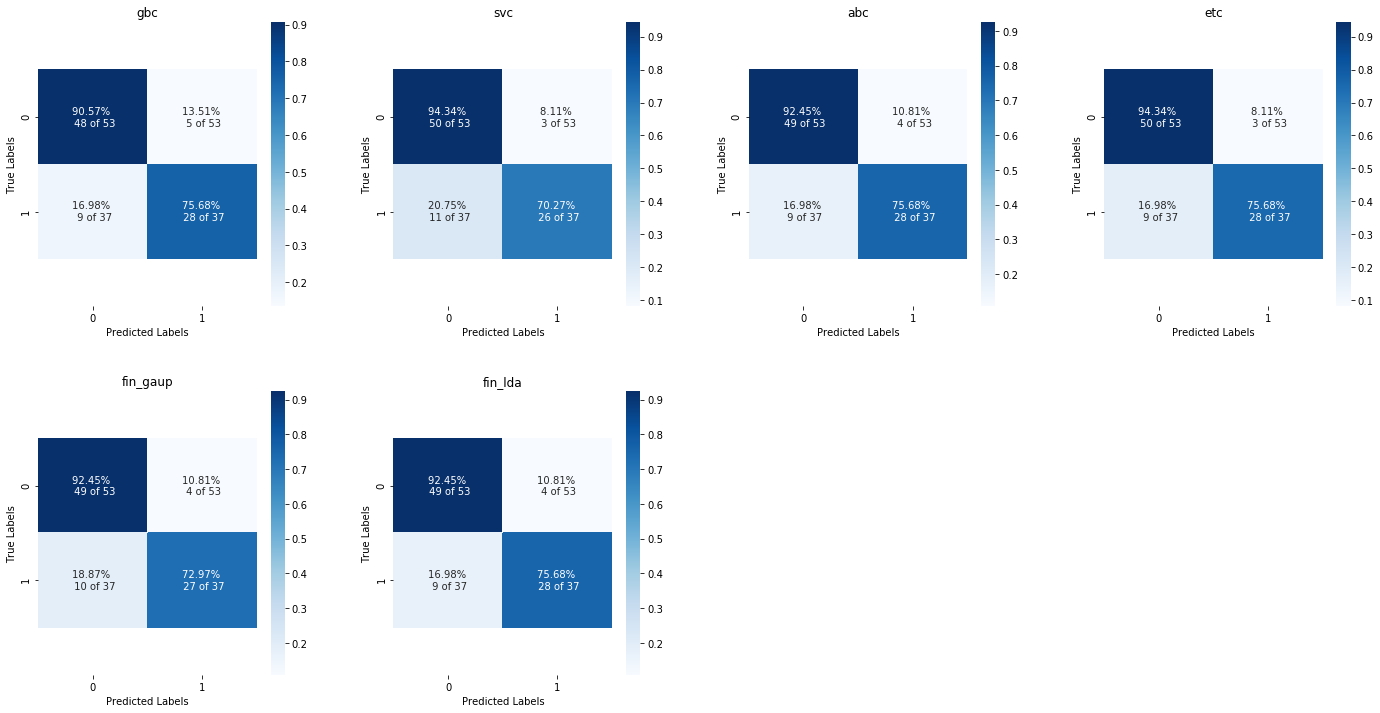

In [235]:
# grd_n = len(final_models_surv)
# grd_cols_n = 4
# grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
# fig = plt.figure()
# fig.set_size_inches(6 * grd_cols_n, 6 * grd_rows_n)
# gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

# for i, m in enumerate(final_models_surv):
#     lbl, model = m
#     plot_confusion_matrix(model, X_test, y_test, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [ ]:
# #feature selection
# dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
# dtree_rfe.fit(data1[data1_x_bin], data1[Target])

# #transform x&y to reduced features and fit new model
# #alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
# rfe_results = model_selection.cross_validate(dtree, data1[X_rfe], data1[Target], cv  = cv_split)

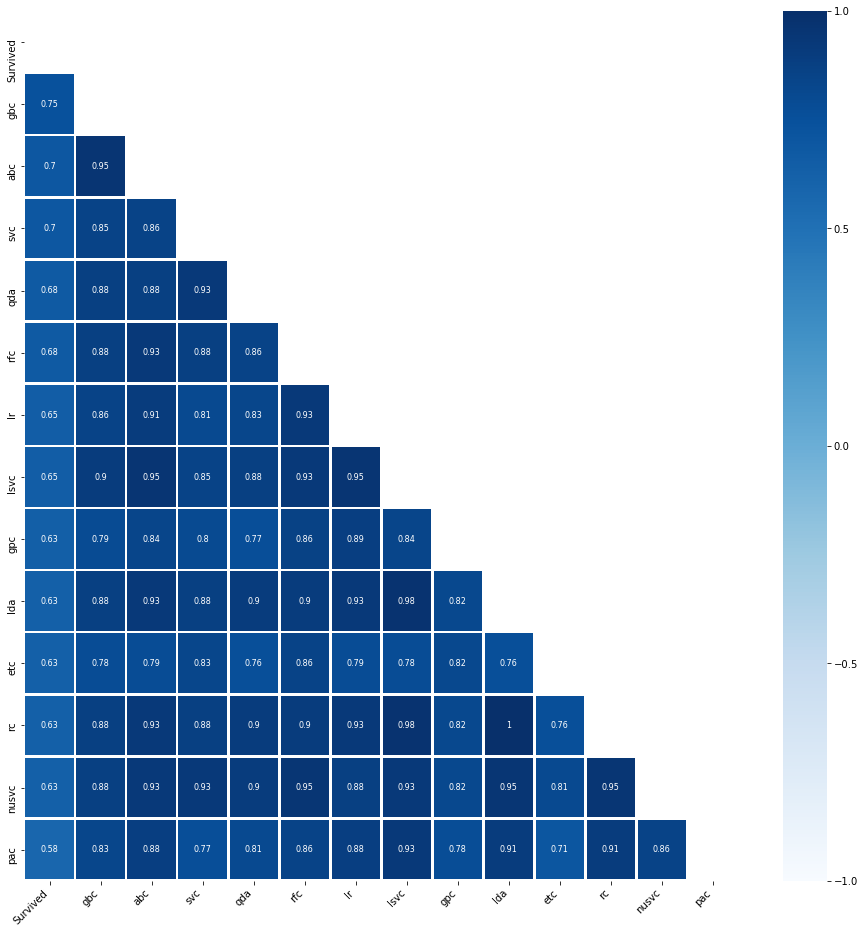

In [231]:
preds_base = base_models_predictions(base_models_surv, X_test)
preds_base = pd.concat([y_test.reset_index().drop(columns=['index']), preds_base], axis=1)
# data = pd.concat([pd.DataFrame(final_model_surv_st.predict_proba(X_test), columns=['final_pred_0', 'final_pred_1']), data], axis=1)
fig = plt.figure()
fig.set_size_inches(16, 16)
corr_matrix = preds_base.corr()
myplt.plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap='Blues')

In [398]:
pred_test = final_model_surv_vt.predict_proba(X_test)
len(pred_test[:,1]>0.9)

90